In [1]:
# pip install scikit-learn optuna

In [2]:
import os, shutil
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import optuna
from sklearn.metrics import f1_score, accuracy_score, roc_curve, auc

from contrastive_siamese import Cfg, Siamese

TRAIN = "emb_csv/train_embeddings.csv"
VAL   = "emb_csv/val_embeddings.csv"
TEST  = "emb_csv/test_embeddings.csv"
STR   = "emb_csv/strangers_embeddings.csv"

VAL_STR  = "emb_csv/val_strangers_embeddings.csv"
TEST_STR = "emb_csv/test_strangers_embeddings.csv"

DEVICE = "cuda"
SEED = 33

# --- 1) make a fixed val/test split of strangers (only run once) ---
if (not Path(VAL_STR).exists()) or (not Path(TEST_STR).exists()):
    df = pd.read_csv(STR).sample(frac=1, random_state=SEED).reset_index(drop=True)
    mid = len(df) // 2
    df.iloc[:mid].to_csv(VAL_STR, index=False)
    df.iloc[mid:].to_csv(TEST_STR, index=False)
    print("Created:", VAL_STR, TEST_STR)

# --- 2) evaluate open-set macro-F1 (known IDs + Stranger) ---
def open_set_macro_f1(model: Siamese, known_csv: str, str_csv: str, sim_th: float) -> float:
    k = model.predict_csv(known_csv)
    u = model.predict_csv(str_csv)

    k_pred = np.where(k["similarity_percent"].to_numpy() < sim_th, "Stranger",
                      k["pred_folder_name"].astype(str).to_numpy())
    u_pred = np.where(u["similarity_percent"].to_numpy() < sim_th, "Stranger",
                      u["pred_folder_name"].astype(str).to_numpy())

    y_true = np.concatenate([k["folder_name"].astype(str).to_numpy(),
                             np.array(["Stranger"] * len(u))])
    y_pred = np.concatenate([k_pred, u_pred])

    return float(f1_score(y_true, y_pred, average="macro"))

# --- 3) binary known-vs-unknown metrics at threshold ---
def known_unknown_metrics(model: Siamese, known_csv: str, str_csv: str, sim_th: float):
    model.cfg.sim_threshold = float(sim_th)
    k = model.predict_csv(known_csv)
    u = model.predict_csv(str_csv)

    ks = k["similarity_percent"].to_numpy()
    us = u["similarity_percent"].to_numpy()

    y_true = np.concatenate([np.ones(len(ks)), np.zeros(len(us))]).astype(int)  # 1=Known
    y_pred = np.concatenate([(ks >= sim_th).astype(int),
                             (us >= sim_th).astype(int)])

    return {
        "acc": float(accuracy_score(y_true, y_pred)),
        "macro_f1": float(f1_score(y_true, y_pred, average="macro")),
        "known_scores": ks,
        "str_scores": us,
    }

def plot_roc(known_scores, str_scores, title):
    y_true = np.concatenate([np.ones(len(known_scores)), np.zeros(len(str_scores))]).astype(int)
    scores = np.concatenate([known_scores, str_scores])
    fpr, tpr, _ = roc_curve(y_true, scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
    plt.plot([0,1],[0,1],"--")
    plt.xlabel("FPR (stranger accepted as known)")
    plt.ylabel("TPR (known accepted)")
    plt.title(title)
    plt.legend()
    plt.show()

def far_on_strangers(model: Siamese, str_csv: str, sim_th: float) -> float:
    out = model.predict_csv(str_csv)
    return float((out["similarity_percent"].to_numpy() >= sim_th).mean())  # accepted-as-known rate


/home/madhav_g/face.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Created: emb_csv/val_strangers_embeddings.csv emb_csv/test_strangers_embeddings.csv


In [3]:
FAR_MAX = 0.05  # 5%

def objective(trial: optuna.Trial) -> float:
    hidden = 256 # trial.suggest_categorical("hidden", [256, 512])
    outdim = 128 # trial.suggest_categorical("outdim", [64, 128])

    hp = dict(
        sizes=(512, hidden, outdim),
        dropout=trial.suggest_float("dropout", 0.0, 0.3),
        margin=trial.suggest_float("margin", 0.5, 1.6),
        lr=trial.suggest_float("lr", 1e-4, 3e-3, log=True),
        weight_decay=trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True),
        epochs=trial.suggest_categorical("epochs", [10, 15, 20]),
        batch_size=trial.suggest_categorical("batch_size", [128, 256]),
        num_pairs_per_epoch=trial.suggest_categorical("num_pairs_per_epoch", [15000, 30000]),
        pos_fraction=1/3,
        prefix="e", folder_col="folder_name", file_col="file_name",
        seed=SEED,
        sim_threshold=trial.suggest_float("sim_threshold", 80.0, 99.0),
    )

    # silence plots inside trials
    import matplotlib.pyplot as plt
    old_show = plt.show
    plt.show = lambda *a, **k: None

    tmp = Path("optuna_tmp")
    shutil.rmtree(tmp, ignore_errors=True)

    m = Siamese(Cfg(**hp), device=DEVICE)
    m.fit(TRAIN, val_csv=VAL, out_dir=tmp)
    m.load_prototypes(tmp / "prototypes.csv")

    # --- constraint: FAR <= 5% on val strangers ---
    far = far_on_strangers(m, VAL_STR, hp["sim_threshold"])
    raw_f1 = open_set_macro_f1(m, VAL, VAL_STR, sim_th=hp["sim_threshold"])
    print(f"FAR on Strangers: {far*100}%")

    trial.set_user_attr("FAR", float(far))
    trial.set_user_attr("raw_open_f1", float(raw_f1))

    # penalty if FAR constraint is violated
    violation = max(0.0, far - FAR_MAX)
    penalty = 5.0
    trial.set_user_attr("violation", float(violation))

    plt.show = old_show
    plt.close("all")

    return raw_f1 - penalty * violation



study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)  # change n_trials

df = study.trials_dataframe(attrs=("number", "value", "params", "user_attrs", "state"))
df.to_csv("optuna_results.csv", index=False)
print("Saved optuna_results.csv with", len(df), "trials")
df.head()

print("Best score:", study.best_value)
print("Best params:", study.best_params)
print("Best trial FAR:", study.best_trial.user_attrs.get("far"))


[I 2025-12-16 08:19:37,957] A new study created in memory with name: no-name-c11d4cd3-00e7-4abc-b783-f5733407dfa9


epoch 001/20 | train_loss=0.129179 | val_loss=0.075590 | train_acc=0.994 | val_acc=0.989
epoch 002/20 | train_loss=0.031298 | val_loss=0.050885 | train_acc=0.997 | val_acc=0.994
epoch 003/20 | train_loss=0.015505 | val_loss=0.040591 | train_acc=0.999 | val_acc=0.994
epoch 004/20 | train_loss=0.008701 | val_loss=0.038306 | train_acc=0.999 | val_acc=0.989
epoch 005/20 | train_loss=0.005603 | val_loss=0.042819 | train_acc=1.000 | val_acc=0.989
epoch 006/20 | train_loss=0.003329 | val_loss=0.043555 | train_acc=1.000 | val_acc=0.983
epoch 007/20 | train_loss=0.002103 | val_loss=0.039940 | train_acc=1.000 | val_acc=0.983
epoch 008/20 | train_loss=0.001461 | val_loss=0.041074 | train_acc=1.000 | val_acc=0.983
epoch 009/20 | train_loss=0.001056 | val_loss=0.043213 | train_acc=1.000 | val_acc=0.977
epoch 010/20 | train_loss=0.000840 | val_loss=0.043732 | train_acc=1.000 | val_acc=0.972
epoch 011/20 | train_loss=0.000720 | val_loss=0.043087 | train_acc=1.000 | val_acc=0.972
epoch 012/20 | train_

[I 2025-12-16 08:19:45,183] Trial 0 finished with value: -0.5929423508019803 and parameters: {'dropout': 0.11667451755685614, 'margin': 1.3977648004118537, 'lr': 0.0008329074555945835, 'weight_decay': 0.00024771307893321683, 'epochs': 20, 'batch_size': 256, 'num_pairs_per_epoch': 15000, 'sim_threshold': 91.34280108811149}. Best is trial 0 with value: -0.5929423508019803.


epoch 020/20 | train_loss=0.000226 | val_loss=0.044164 | train_acc=1.000 | val_acc=0.977
saved plot: optuna_tmp/curves_margin1.3977648004118537.png
saved: optuna_tmp/siamese_model.pt and optuna_tmp/prototypes.csv
FAR on Strangers: 34.78260869565217%
epoch 001/10 | train_loss=0.055245 | val_loss=0.029302 | train_acc=0.999 | val_acc=0.994
epoch 002/10 | train_loss=0.008852 | val_loss=0.028605 | train_acc=1.000 | val_acc=0.983
epoch 003/10 | train_loss=0.002137 | val_loss=0.031932 | train_acc=1.000 | val_acc=0.977
epoch 004/10 | train_loss=0.000705 | val_loss=0.033848 | train_acc=1.000 | val_acc=0.977
epoch 005/10 | train_loss=0.000337 | val_loss=0.033077 | train_acc=1.000 | val_acc=0.977
epoch 006/10 | train_loss=0.000422 | val_loss=0.026004 | train_acc=1.000 | val_acc=0.994
epoch 007/10 | train_loss=0.000453 | val_loss=0.047574 | train_acc=1.000 | val_acc=0.972
epoch 008/10 | train_loss=0.000714 | val_loss=0.032030 | train_acc=1.000 | val_acc=0.977
epoch 009/10 | train_loss=0.000196 | v

[I 2025-12-16 08:19:52,778] Trial 1 finished with value: -1.0336745841772825 and parameters: {'dropout': 0.2977256618961614, 'margin': 1.1474397624159212, 'lr': 0.000564601884689684, 'weight_decay': 2.2936589371032315e-06, 'epochs': 10, 'batch_size': 128, 'num_pairs_per_epoch': 30000, 'sim_threshold': 90.66575763326955}. Best is trial 0 with value: -0.5929423508019803.


epoch 010/10 | train_loss=0.000211 | val_loss=0.034129 | train_acc=1.000 | val_acc=0.977
saved plot: optuna_tmp/curves_margin1.1474397624159212.png
saved: optuna_tmp/siamese_model.pt and optuna_tmp/prototypes.csv
FAR on Strangers: 43.47826086956522%
epoch 001/10 | train_loss=0.008243 | val_loss=0.008368 | train_acc=0.999 | val_acc=0.994
epoch 002/10 | train_loss=0.002226 | val_loss=0.007674 | train_acc=0.999 | val_acc=0.994
epoch 003/10 | train_loss=0.001338 | val_loss=0.007528 | train_acc=1.000 | val_acc=0.994
epoch 004/10 | train_loss=0.000928 | val_loss=0.007178 | train_acc=1.000 | val_acc=0.994
epoch 005/10 | train_loss=0.000676 | val_loss=0.006562 | train_acc=1.000 | val_acc=0.994
epoch 006/10 | train_loss=0.000514 | val_loss=0.006204 | train_acc=1.000 | val_acc=0.994
epoch 007/10 | train_loss=0.000407 | val_loss=0.005978 | train_acc=1.000 | val_acc=0.994
epoch 008/10 | train_loss=0.000315 | val_loss=0.005719 | train_acc=1.000 | val_acc=0.994
epoch 009/10 | train_loss=0.000244 | v

[I 2025-12-16 08:20:00,319] Trial 2 finished with value: -1.6484461833164492 and parameters: {'dropout': 0.0334199070936105, 'margin': 0.500359332223872, 'lr': 0.0002710699699782735, 'weight_decay': 0.0004154569264864657, 'epochs': 10, 'batch_size': 128, 'num_pairs_per_epoch': 30000, 'sim_threshold': 87.08627241209102}. Best is trial 0 with value: -0.5929423508019803.


epoch 010/10 | train_loss=0.000199 | val_loss=0.005232 | train_acc=1.000 | val_acc=0.989
saved plot: optuna_tmp/curves_margin0.500359332223872.png
saved: optuna_tmp/siamese_model.pt and optuna_tmp/prototypes.csv
FAR on Strangers: 56.52173913043478%
epoch 001/15 | train_loss=0.053196 | val_loss=0.024657 | train_acc=0.992 | val_acc=0.994
epoch 002/15 | train_loss=0.021658 | val_loss=0.018512 | train_acc=0.994 | val_acc=0.994
epoch 003/15 | train_loss=0.014177 | val_loss=0.016758 | train_acc=0.997 | val_acc=0.994
epoch 004/15 | train_loss=0.010582 | val_loss=0.016303 | train_acc=0.999 | val_acc=0.994
epoch 005/15 | train_loss=0.008561 | val_loss=0.015309 | train_acc=0.999 | val_acc=0.994
epoch 006/15 | train_loss=0.007205 | val_loss=0.015114 | train_acc=0.999 | val_acc=0.994
epoch 007/15 | train_loss=0.005850 | val_loss=0.015189 | train_acc=0.999 | val_acc=0.994
epoch 008/15 | train_loss=0.005137 | val_loss=0.014967 | train_acc=0.999 | val_acc=0.994
epoch 009/15 | train_loss=0.004338 | va

[I 2025-12-16 08:20:05,098] Trial 3 finished with value: 0.7595851289888604 and parameters: {'dropout': 0.15550459452291954, 'margin': 0.7636474663011117, 'lr': 0.0002543199436433294, 'weight_decay': 5.177881044497895e-06, 'epochs': 15, 'batch_size': 256, 'num_pairs_per_epoch': 15000, 'sim_threshold': 89.19108350980001}. Best is trial 3 with value: 0.7595851289888604.


FAR on Strangers: 8.695652173913043%
epoch 001/10 | train_loss=0.022244 | val_loss=0.012181 | train_acc=0.998 | val_acc=0.994
epoch 002/10 | train_loss=0.006841 | val_loss=0.010584 | train_acc=0.999 | val_acc=0.994
epoch 003/10 | train_loss=0.004435 | val_loss=0.011054 | train_acc=0.999 | val_acc=0.994
epoch 004/10 | train_loss=0.003065 | val_loss=0.010829 | train_acc=0.999 | val_acc=0.994
epoch 005/10 | train_loss=0.002235 | val_loss=0.010835 | train_acc=1.000 | val_acc=0.994
epoch 006/10 | train_loss=0.001654 | val_loss=0.010584 | train_acc=1.000 | val_acc=0.983
epoch 007/10 | train_loss=0.001207 | val_loss=0.010126 | train_acc=1.000 | val_acc=0.983
epoch 008/10 | train_loss=0.000890 | val_loss=0.009444 | train_acc=1.000 | val_acc=0.983
epoch 009/10 | train_loss=0.000651 | val_loss=0.009682 | train_acc=1.000 | val_acc=0.977


[I 2025-12-16 08:20:08,279] Trial 4 finished with value: -1.6582887202619343 and parameters: {'dropout': 0.15937063131411763, 'margin': 0.6458786181393653, 'lr': 0.0008320445879436858, 'weight_decay': 1.3059760303233034e-05, 'epochs': 10, 'batch_size': 256, 'num_pairs_per_epoch': 15000, 'sim_threshold': 85.59050680175501}. Best is trial 3 with value: 0.7595851289888604.


epoch 010/10 | train_loss=0.000497 | val_loss=0.008760 | train_acc=1.000 | val_acc=0.983
saved plot: optuna_tmp/curves_margin0.6458786181393653.png
saved: optuna_tmp/siamese_model.pt and optuna_tmp/prototypes.csv
FAR on Strangers: 56.52173913043478%
epoch 001/10 | train_loss=0.041329 | val_loss=0.026441 | train_acc=0.998 | val_acc=0.994
epoch 002/10 | train_loss=0.007325 | val_loss=0.021259 | train_acc=0.999 | val_acc=0.994
epoch 003/10 | train_loss=0.003055 | val_loss=0.027877 | train_acc=1.000 | val_acc=0.989
epoch 004/10 | train_loss=0.001221 | val_loss=0.027154 | train_acc=1.000 | val_acc=0.983
epoch 005/10 | train_loss=0.000596 | val_loss=0.035704 | train_acc=1.000 | val_acc=0.972
epoch 006/10 | train_loss=0.000323 | val_loss=0.030234 | train_acc=1.000 | val_acc=0.983
epoch 007/10 | train_loss=0.000153 | val_loss=0.038349 | train_acc=1.000 | val_acc=0.972
epoch 008/10 | train_loss=0.000081 | val_loss=0.042045 | train_acc=1.000 | val_acc=0.972
epoch 009/10 | train_loss=0.000549 | v

[I 2025-12-16 08:20:11,460] Trial 5 finished with value: -1.6626724294834676 and parameters: {'dropout': 0.2706232393339424, 'margin': 0.9780145681047769, 'lr': 0.0028006221457412086, 'weight_decay': 3.4807886902352206e-05, 'epochs': 10, 'batch_size': 256, 'num_pairs_per_epoch': 15000, 'sim_threshold': 80.26863153632019}. Best is trial 3 with value: 0.7595851289888604.


epoch 010/10 | train_loss=0.000123 | val_loss=0.027372 | train_acc=1.000 | val_acc=0.983
saved plot: optuna_tmp/curves_margin0.9780145681047769.png
saved: optuna_tmp/siamese_model.pt and optuna_tmp/prototypes.csv
FAR on Strangers: 56.52173913043478%
epoch 001/20 | train_loss=0.119706 | val_loss=0.071698 | train_acc=0.993 | val_acc=0.994
epoch 002/20 | train_loss=0.031614 | val_loss=0.050580 | train_acc=0.998 | val_acc=0.994
epoch 003/20 | train_loss=0.016215 | val_loss=0.041581 | train_acc=0.999 | val_acc=0.994
epoch 004/20 | train_loss=0.010567 | val_loss=0.038539 | train_acc=0.999 | val_acc=0.994
epoch 005/20 | train_loss=0.007496 | val_loss=0.038707 | train_acc=0.999 | val_acc=0.994
epoch 006/20 | train_loss=0.005169 | val_loss=0.043354 | train_acc=1.000 | val_acc=0.977
epoch 007/20 | train_loss=0.003529 | val_loss=0.043024 | train_acc=1.000 | val_acc=0.977
epoch 008/20 | train_loss=0.002597 | val_loss=0.042113 | train_acc=1.000 | val_acc=0.977
epoch 009/20 | train_loss=0.002002 | v

[I 2025-12-16 08:20:26,462] Trial 6 finished with value: -0.820859081166607 and parameters: {'dropout': 0.04264803450322996, 'margin': 1.291145645290337, 'lr': 0.00011178828480603269, 'weight_decay': 6.80615434671897e-05, 'epochs': 20, 'batch_size': 128, 'num_pairs_per_epoch': 30000, 'sim_threshold': 90.26203823237768}. Best is trial 3 with value: 0.7595851289888604.


epoch 020/20 | train_loss=0.000204 | val_loss=0.051547 | train_acc=1.000 | val_acc=0.972
saved plot: optuna_tmp/curves_margin1.291145645290337.png
saved: optuna_tmp/siamese_model.pt and optuna_tmp/prototypes.csv
FAR on Strangers: 39.130434782608695%
epoch 001/10 | train_loss=0.083140 | val_loss=0.043835 | train_acc=0.998 | val_acc=0.994
epoch 002/10 | train_loss=0.012956 | val_loss=0.034266 | train_acc=0.999 | val_acc=0.989
epoch 003/10 | train_loss=0.004706 | val_loss=0.046424 | train_acc=1.000 | val_acc=0.983
epoch 004/10 | train_loss=0.001344 | val_loss=0.041588 | train_acc=1.000 | val_acc=0.989
epoch 005/10 | train_loss=0.000979 | val_loss=0.036401 | train_acc=1.000 | val_acc=0.989
epoch 006/10 | train_loss=0.000281 | val_loss=0.064849 | train_acc=1.000 | val_acc=0.972
epoch 007/10 | train_loss=0.000558 | val_loss=0.040976 | train_acc=1.000 | val_acc=0.983
epoch 008/10 | train_loss=0.001035 | val_loss=0.042453 | train_acc=1.000 | val_acc=0.983
epoch 009/10 | train_loss=0.000107 | v

[I 2025-12-16 08:20:30,427] Trial 7 finished with value: -1.2422928148006371 and parameters: {'dropout': 0.21819634621250597, 'margin': 1.3854014333896414, 'lr': 0.0011926525468717046, 'weight_decay': 9.92746173182696e-06, 'epochs': 10, 'batch_size': 128, 'num_pairs_per_epoch': 15000, 'sim_threshold': 85.54803746708716}. Best is trial 3 with value: 0.7595851289888604.


epoch 010/10 | train_loss=0.000214 | val_loss=0.048968 | train_acc=1.000 | val_acc=0.983
saved plot: optuna_tmp/curves_margin1.3854014333896414.png
saved: optuna_tmp/siamese_model.pt and optuna_tmp/prototypes.csv
FAR on Strangers: 47.82608695652174%
epoch 001/20 | train_loss=0.031726 | val_loss=0.026261 | train_acc=0.998 | val_acc=0.994
epoch 002/20 | train_loss=0.007739 | val_loss=0.018459 | train_acc=0.999 | val_acc=0.994
epoch 003/20 | train_loss=0.004459 | val_loss=0.016651 | train_acc=0.999 | val_acc=0.994
epoch 004/20 | train_loss=0.002922 | val_loss=0.015988 | train_acc=0.999 | val_acc=0.994
epoch 005/20 | train_loss=0.002112 | val_loss=0.015857 | train_acc=1.000 | val_acc=0.989
epoch 006/20 | train_loss=0.001534 | val_loss=0.015800 | train_acc=1.000 | val_acc=0.977
epoch 007/20 | train_loss=0.001143 | val_loss=0.015356 | train_acc=1.000 | val_acc=0.977
epoch 008/20 | train_loss=0.000908 | val_loss=0.014882 | train_acc=1.000 | val_acc=0.977
epoch 009/20 | train_loss=0.000735 | v

[I 2025-12-16 08:20:36,582] Trial 8 finished with value: 0.8694688168593266 and parameters: {'dropout': 0.01724889626545507, 'margin': 0.8409444170135625, 'lr': 0.0007826369072691036, 'weight_decay': 0.00017946826072987452, 'epochs': 20, 'batch_size': 256, 'num_pairs_per_epoch': 15000, 'sim_threshold': 97.36908207189529}. Best is trial 8 with value: 0.8694688168593266.


epoch 020/20 | train_loss=0.000136 | val_loss=0.016908 | train_acc=1.000 | val_acc=0.977
saved plot: optuna_tmp/curves_margin0.8409444170135625.png
saved: optuna_tmp/siamese_model.pt and optuna_tmp/prototypes.csv
FAR on Strangers: 4.3478260869565215%
epoch 001/15 | train_loss=0.060717 | val_loss=0.038072 | train_acc=0.999 | val_acc=0.989
epoch 002/15 | train_loss=0.004739 | val_loss=0.072573 | train_acc=1.000 | val_acc=0.972
epoch 003/15 | train_loss=0.001173 | val_loss=0.067558 | train_acc=1.000 | val_acc=0.972
epoch 004/15 | train_loss=0.000685 | val_loss=0.069279 | train_acc=1.000 | val_acc=0.972
epoch 005/15 | train_loss=0.000685 | val_loss=0.059956 | train_acc=1.000 | val_acc=0.972
epoch 006/15 | train_loss=0.000482 | val_loss=0.070870 | train_acc=1.000 | val_acc=0.972
epoch 007/15 | train_loss=0.000935 | val_loss=0.071589 | train_acc=1.000 | val_acc=0.972
epoch 008/15 | train_loss=0.001233 | val_loss=0.055193 | train_acc=1.000 | val_acc=0.977
epoch 009/15 | train_loss=0.000608 | 

[I 2025-12-16 08:20:47,969] Trial 9 finished with value: -1.488077838343885 and parameters: {'dropout': 0.17666833134088583, 'margin': 1.514558256550172, 'lr': 0.0010335283840795723, 'weight_decay': 1.1432113954311718e-06, 'epochs': 15, 'batch_size': 128, 'num_pairs_per_epoch': 30000, 'sim_threshold': 92.36473748290854}. Best is trial 8 with value: 0.8694688168593266.


epoch 015/15 | train_loss=0.000424 | val_loss=0.066451 | train_acc=1.000 | val_acc=0.966
saved plot: optuna_tmp/curves_margin1.514558256550172.png
saved: optuna_tmp/siamese_model.pt and optuna_tmp/prototypes.csv
FAR on Strangers: 52.17391304347826%
epoch 001/20 | train_loss=0.029420 | val_loss=0.021058 | train_acc=0.998 | val_acc=0.994
epoch 002/20 | train_loss=0.005234 | val_loss=0.016350 | train_acc=0.999 | val_acc=0.994
epoch 003/20 | train_loss=0.002515 | val_loss=0.018650 | train_acc=1.000 | val_acc=0.989
epoch 004/20 | train_loss=0.001131 | val_loss=0.018848 | train_acc=1.000 | val_acc=0.989
epoch 005/20 | train_loss=0.000645 | val_loss=0.017725 | train_acc=1.000 | val_acc=0.983
epoch 006/20 | train_loss=0.000369 | val_loss=0.019383 | train_acc=1.000 | val_acc=0.977
epoch 007/20 | train_loss=0.000277 | val_loss=0.021371 | train_acc=1.000 | val_acc=0.972
epoch 008/20 | train_loss=0.000214 | val_loss=0.020181 | train_acc=1.000 | val_acc=0.977
epoch 009/20 | train_loss=0.000130 | va

[I 2025-12-16 08:20:54,197] Trial 10 finished with value: 0.2338157386305263 and parameters: {'dropout': 0.0910467054876874, 'margin': 0.9118935169667969, 'lr': 0.002423220727156109, 'weight_decay': 0.00011993819249304, 'epochs': 20, 'batch_size': 256, 'num_pairs_per_epoch': 15000, 'sim_threshold': 98.91094732668816}. Best is trial 8 with value: 0.8694688168593266.


epoch 020/20 | train_loss=0.000006 | val_loss=0.030006 | train_acc=1.000 | val_acc=0.972
saved plot: optuna_tmp/curves_margin0.9118935169667969.png
saved: optuna_tmp/siamese_model.pt and optuna_tmp/prototypes.csv
FAR on Strangers: 17.391304347826086%
epoch 001/15 | train_loss=0.044014 | val_loss=0.031407 | train_acc=0.991 | val_acc=0.994
epoch 002/15 | train_loss=0.015969 | val_loss=0.024314 | train_acc=0.994 | val_acc=0.994
epoch 003/15 | train_loss=0.009944 | val_loss=0.020279 | train_acc=0.997 | val_acc=0.994
epoch 004/15 | train_loss=0.006760 | val_loss=0.018267 | train_acc=0.999 | val_acc=0.994
epoch 005/15 | train_loss=0.005161 | val_loss=0.016308 | train_acc=0.999 | val_acc=0.994
epoch 006/15 | train_loss=0.004102 | val_loss=0.015303 | train_acc=0.999 | val_acc=0.994
epoch 007/15 | train_loss=0.003133 | val_loss=0.015080 | train_acc=0.999 | val_acc=0.994
epoch 008/15 | train_loss=0.002768 | val_loss=0.014564 | train_acc=0.999 | val_acc=0.994
epoch 009/15 | train_loss=0.002278 | 

[I 2025-12-16 08:20:58,871] Trial 11 finished with value: 0.8343863799036213 and parameters: {'dropout': 0.006809390171472224, 'margin': 0.7529107554885766, 'lr': 0.000215812688762267, 'weight_decay': 6.110451020546432e-06, 'epochs': 15, 'batch_size': 256, 'num_pairs_per_epoch': 15000, 'sim_threshold': 95.8374747057265}. Best is trial 8 with value: 0.8694688168593266.


epoch 015/15 | train_loss=0.001148 | val_loss=0.013191 | train_acc=1.000 | val_acc=0.994
saved plot: optuna_tmp/curves_margin0.7529107554885766.png
saved: optuna_tmp/siamese_model.pt and optuna_tmp/prototypes.csv
FAR on Strangers: 4.3478260869565215%
epoch 001/15 | train_loss=0.045176 | val_loss=0.034412 | train_acc=0.993 | val_acc=0.994
epoch 002/15 | train_loss=0.015344 | val_loss=0.026104 | train_acc=0.995 | val_acc=0.994
epoch 003/15 | train_loss=0.009348 | val_loss=0.022139 | train_acc=0.999 | val_acc=0.994
epoch 004/15 | train_loss=0.006180 | val_loss=0.020557 | train_acc=0.999 | val_acc=0.994
epoch 005/15 | train_loss=0.004497 | val_loss=0.018924 | train_acc=0.999 | val_acc=0.994
epoch 006/15 | train_loss=0.003409 | val_loss=0.017796 | train_acc=0.999 | val_acc=0.994
epoch 007/15 | train_loss=0.002544 | val_loss=0.017863 | train_acc=0.999 | val_acc=0.994
epoch 008/15 | train_loss=0.002132 | val_loss=0.017441 | train_acc=1.000 | val_acc=0.994
epoch 009/15 | train_loss=0.001703 | 

[I 2025-12-16 08:21:03,566] Trial 12 finished with value: 0.41393515575333756 and parameters: {'dropout': 0.0028603594279122176, 'margin': 0.7883062516899844, 'lr': 0.0002694314535683288, 'weight_decay': 0.0009320748131747953, 'epochs': 15, 'batch_size': 256, 'num_pairs_per_epoch': 15000, 'sim_threshold': 98.54082900382726}. Best is trial 8 with value: 0.8694688168593266.


epoch 015/15 | train_loss=0.000682 | val_loss=0.016521 | train_acc=1.000 | val_acc=0.994
saved plot: optuna_tmp/curves_margin0.7883062516899844.png
saved: optuna_tmp/siamese_model.pt and optuna_tmp/prototypes.csv
FAR on Strangers: 0.0%
epoch 001/15 | train_loss=0.173017 | val_loss=0.073761 | train_acc=0.989 | val_acc=0.989
epoch 002/15 | train_loss=0.067495 | val_loss=0.061800 | train_acc=0.993 | val_acc=0.994
epoch 003/15 | train_loss=0.046922 | val_loss=0.052694 | train_acc=0.993 | val_acc=0.994
epoch 004/15 | train_loss=0.034810 | val_loss=0.046522 | train_acc=0.994 | val_acc=0.994
epoch 005/15 | train_loss=0.027053 | val_loss=0.040516 | train_acc=0.995 | val_acc=0.994
epoch 006/15 | train_loss=0.022046 | val_loss=0.038204 | train_acc=0.996 | val_acc=0.994
epoch 007/15 | train_loss=0.018410 | val_loss=0.036030 | train_acc=0.997 | val_acc=0.994
epoch 008/15 | train_loss=0.015997 | val_loss=0.034562 | train_acc=0.997 | val_acc=0.994
epoch 009/15 | train_loss=0.013850 | val_loss=0.0329

[I 2025-12-16 08:21:08,239] Trial 13 finished with value: 0.7698850367229683 and parameters: {'dropout': 0.0756523047612509, 'margin': 1.1134399741942471, 'lr': 0.00012265523013668775, 'weight_decay': 2.2769195646002513e-05, 'epochs': 15, 'batch_size': 256, 'num_pairs_per_epoch': 15000, 'sim_threshold': 95.17535523737784}. Best is trial 8 with value: 0.8694688168593266.


epoch 015/15 | train_loss=0.007121 | val_loss=0.028306 | train_acc=0.999 | val_acc=0.994
saved plot: optuna_tmp/curves_margin1.1134399741942471.png
saved: optuna_tmp/siamese_model.pt and optuna_tmp/prototypes.csv
FAR on Strangers: 0.0%
epoch 001/20 | train_loss=0.038464 | val_loss=0.030894 | train_acc=0.993 | val_acc=0.994
epoch 002/20 | train_loss=0.010559 | val_loss=0.022047 | train_acc=0.997 | val_acc=0.994
epoch 003/20 | train_loss=0.005899 | val_loss=0.019466 | train_acc=0.999 | val_acc=0.994
epoch 004/20 | train_loss=0.003703 | val_loss=0.017674 | train_acc=0.999 | val_acc=0.994
epoch 005/20 | train_loss=0.002663 | val_loss=0.016393 | train_acc=0.999 | val_acc=0.994
epoch 006/20 | train_loss=0.002001 | val_loss=0.015380 | train_acc=0.999 | val_acc=0.994
epoch 007/20 | train_loss=0.001403 | val_loss=0.015595 | train_acc=0.999 | val_acc=0.994
epoch 008/20 | train_loss=0.001222 | val_loss=0.015322 | train_acc=0.999 | val_acc=0.994
epoch 009/20 | train_loss=0.000868 | val_loss=0.0155

[I 2025-12-16 08:21:14,416] Trial 14 finished with value: 0.7160887648744558 and parameters: {'dropout': 4.944405880148717e-06, 'margin': 0.8296813688034415, 'lr': 0.0004378091738406067, 'weight_decay': 4.332483016727143e-06, 'epochs': 20, 'batch_size': 256, 'num_pairs_per_epoch': 15000, 'sim_threshold': 95.1277427257975}. Best is trial 8 with value: 0.8694688168593266.


epoch 020/20 | train_loss=0.000129 | val_loss=0.015699 | train_acc=1.000 | val_acc=0.977
saved plot: optuna_tmp/curves_margin0.8296813688034415.png
saved: optuna_tmp/siamese_model.pt and optuna_tmp/prototypes.csv
FAR on Strangers: 8.695652173913043%
epoch 001/15 | train_loss=0.039869 | val_loss=0.025505 | train_acc=0.991 | val_acc=0.989
epoch 002/15 | train_loss=0.017743 | val_loss=0.019187 | train_acc=0.996 | val_acc=0.994
epoch 003/15 | train_loss=0.011505 | val_loss=0.016312 | train_acc=0.996 | val_acc=0.994
epoch 004/15 | train_loss=0.008361 | val_loss=0.014940 | train_acc=0.998 | val_acc=0.994
epoch 005/15 | train_loss=0.006640 | val_loss=0.013606 | train_acc=0.999 | val_acc=0.994
epoch 006/15 | train_loss=0.005418 | val_loss=0.013208 | train_acc=0.999 | val_acc=0.994
epoch 007/15 | train_loss=0.004465 | val_loss=0.012947 | train_acc=0.999 | val_acc=0.994
epoch 008/15 | train_loss=0.004056 | val_loss=0.012725 | train_acc=0.999 | val_acc=0.994
epoch 009/15 | train_loss=0.003458 | v

[I 2025-12-16 08:21:19,137] Trial 15 finished with value: 0.8562170873859185 and parameters: {'dropout': 0.05350194306639665, 'margin': 0.6694187166640535, 'lr': 0.00016796156078858563, 'weight_decay': 9.230287027733725e-05, 'epochs': 15, 'batch_size': 256, 'num_pairs_per_epoch': 15000, 'sim_threshold': 95.49513306201855}. Best is trial 8 with value: 0.8694688168593266.


epoch 015/15 | train_loss=0.001951 | val_loss=0.011619 | train_acc=0.999 | val_acc=0.994
saved plot: optuna_tmp/curves_margin0.6694187166640535.png
saved: optuna_tmp/siamese_model.pt and optuna_tmp/prototypes.csv
FAR on Strangers: 0.0%
epoch 001/20 | train_loss=0.011669 | val_loss=0.008643 | train_acc=0.998 | val_acc=0.994
epoch 002/20 | train_loss=0.002785 | val_loss=0.007834 | train_acc=0.999 | val_acc=0.994
epoch 003/20 | train_loss=0.001628 | val_loss=0.007605 | train_acc=1.000 | val_acc=0.989
epoch 004/20 | train_loss=0.001055 | val_loss=0.007529 | train_acc=1.000 | val_acc=0.983
epoch 005/20 | train_loss=0.000694 | val_loss=0.007654 | train_acc=1.000 | val_acc=0.983
epoch 006/20 | train_loss=0.000491 | val_loss=0.007291 | train_acc=1.000 | val_acc=0.983
epoch 007/20 | train_loss=0.000354 | val_loss=0.007342 | train_acc=1.000 | val_acc=0.977
epoch 008/20 | train_loss=0.000291 | val_loss=0.006892 | train_acc=1.000 | val_acc=0.983
epoch 009/20 | train_loss=0.000182 | val_loss=0.0067

[I 2025-12-16 08:21:25,291] Trial 16 finished with value: 0.054258542179552616 and parameters: {'dropout': 0.08158985520611213, 'margin': 0.5802834054028627, 'lr': 0.0016641589912900722, 'weight_decay': 0.0001229541780049243, 'epochs': 20, 'batch_size': 256, 'num_pairs_per_epoch': 15000, 'sim_threshold': 96.55547637780413}. Best is trial 8 with value: 0.8694688168593266.


epoch 020/20 | train_loss=0.000148 | val_loss=0.007281 | train_acc=1.000 | val_acc=0.977
saved plot: optuna_tmp/curves_margin0.5802834054028627.png
saved: optuna_tmp/siamese_model.pt and optuna_tmp/prototypes.csv
FAR on Strangers: 21.73913043478261%
epoch 001/20 | train_loss=0.025126 | val_loss=0.017003 | train_acc=0.995 | val_acc=0.994
epoch 002/20 | train_loss=0.007916 | val_loss=0.012717 | train_acc=0.998 | val_acc=0.994
epoch 003/20 | train_loss=0.004949 | val_loss=0.012052 | train_acc=0.999 | val_acc=0.994
epoch 004/20 | train_loss=0.003532 | val_loss=0.011417 | train_acc=0.999 | val_acc=0.994
epoch 005/20 | train_loss=0.002788 | val_loss=0.011148 | train_acc=0.999 | val_acc=0.994
epoch 006/20 | train_loss=0.002188 | val_loss=0.010817 | train_acc=0.999 | val_acc=0.994
epoch 007/20 | train_loss=0.001708 | val_loss=0.010968 | train_acc=1.000 | val_acc=0.994
epoch 008/20 | train_loss=0.001483 | val_loss=0.010702 | train_acc=1.000 | val_acc=0.994
epoch 009/20 | train_loss=0.001222 | v

[I 2025-12-16 08:21:31,607] Trial 17 finished with value: 0.7440084481540967 and parameters: {'dropout': 0.04883410558044003, 'margin': 0.649239089673332, 'lr': 0.00047408089063871365, 'weight_decay': 4.786766509717343e-05, 'epochs': 20, 'batch_size': 256, 'num_pairs_per_epoch': 15000, 'sim_threshold': 93.30296992182694}. Best is trial 8 with value: 0.8694688168593266.


saved plot: optuna_tmp/curves_margin0.649239089673332.png
saved: optuna_tmp/siamese_model.pt and optuna_tmp/prototypes.csv
FAR on Strangers: 8.695652173913043%
epoch 001/15 | train_loss=0.076537 | val_loss=0.040196 | train_acc=0.994 | val_acc=0.989
epoch 002/15 | train_loss=0.025904 | val_loss=0.029833 | train_acc=0.999 | val_acc=0.994
epoch 003/15 | train_loss=0.015398 | val_loss=0.025952 | train_acc=0.999 | val_acc=0.994
epoch 004/15 | train_loss=0.010878 | val_loss=0.024198 | train_acc=0.999 | val_acc=0.994
epoch 005/15 | train_loss=0.008358 | val_loss=0.023298 | train_acc=0.999 | val_acc=0.994
epoch 006/15 | train_loss=0.006519 | val_loss=0.022715 | train_acc=1.000 | val_acc=0.994
epoch 007/15 | train_loss=0.005108 | val_loss=0.022443 | train_acc=1.000 | val_acc=0.994
epoch 008/15 | train_loss=0.003979 | val_loss=0.021751 | train_acc=1.000 | val_acc=0.994
epoch 009/15 | train_loss=0.003276 | val_loss=0.021529 | train_acc=1.000 | val_acc=0.994
epoch 010/15 | train_loss=0.002721 | va

[I 2025-12-16 08:21:40,700] Trial 18 finished with value: 0.8990745244927819 and parameters: {'dropout': 0.10764875228072056, 'margin': 0.9735724947024597, 'lr': 0.00016823273162837847, 'weight_decay': 0.00034487374541538273, 'epochs': 15, 'batch_size': 256, 'num_pairs_per_epoch': 30000, 'sim_threshold': 93.83459105473662}. Best is trial 18 with value: 0.8990745244927819.


epoch 015/15 | train_loss=0.001068 | val_loss=0.021549 | train_acc=1.000 | val_acc=0.983
saved plot: optuna_tmp/curves_margin0.9735724947024597.png
saved: optuna_tmp/siamese_model.pt and optuna_tmp/prototypes.csv
FAR on Strangers: 4.3478260869565215%
epoch 001/20 | train_loss=0.069923 | val_loss=0.033712 | train_acc=0.995 | val_acc=0.994
epoch 002/20 | train_loss=0.020225 | val_loss=0.027235 | train_acc=0.999 | val_acc=0.994
epoch 003/20 | train_loss=0.010865 | val_loss=0.025226 | train_acc=0.999 | val_acc=0.994
epoch 004/20 | train_loss=0.006662 | val_loss=0.025206 | train_acc=1.000 | val_acc=0.989
epoch 005/20 | train_loss=0.004184 | val_loss=0.025299 | train_acc=1.000 | val_acc=0.989
epoch 006/20 | train_loss=0.002651 | val_loss=0.025375 | train_acc=1.000 | val_acc=0.983
epoch 007/20 | train_loss=0.001722 | val_loss=0.025725 | train_acc=1.000 | val_acc=0.977
epoch 008/20 | train_loss=0.001140 | val_loss=0.025601 | train_acc=1.000 | val_acc=0.977
epoch 009/20 | train_loss=0.000726 | 

[I 2025-12-16 08:21:52,682] Trial 19 finished with value: -0.6059130446318207 and parameters: {'dropout': 0.21143541691409784, 'margin': 1.026458276718441, 'lr': 0.0003677834889585812, 'weight_decay': 0.0003283942919637606, 'epochs': 20, 'batch_size': 256, 'num_pairs_per_epoch': 30000, 'sim_threshold': 93.31224714077621}. Best is trial 18 with value: 0.8990745244927819.


epoch 020/20 | train_loss=0.000069 | val_loss=0.031535 | train_acc=1.000 | val_acc=0.972
saved plot: optuna_tmp/curves_margin1.026458276718441.png
saved: optuna_tmp/siamese_model.pt and optuna_tmp/prototypes.csv
FAR on Strangers: 34.78260869565217%
epoch 001/15 | train_loss=0.062340 | val_loss=0.040277 | train_acc=0.995 | val_acc=0.994
epoch 002/15 | train_loss=0.012328 | val_loss=0.031280 | train_acc=0.999 | val_acc=0.994
epoch 003/15 | train_loss=0.005481 | val_loss=0.030208 | train_acc=1.000 | val_acc=0.989
epoch 004/15 | train_loss=0.002776 | val_loss=0.033541 | train_acc=1.000 | val_acc=0.977
epoch 005/15 | train_loss=0.001544 | val_loss=0.033634 | train_acc=1.000 | val_acc=0.977
epoch 006/15 | train_loss=0.000891 | val_loss=0.036052 | train_acc=1.000 | val_acc=0.977
epoch 007/15 | train_loss=0.000574 | val_loss=0.035653 | train_acc=1.000 | val_acc=0.977
epoch 008/15 | train_loss=0.000374 | val_loss=0.036296 | train_acc=1.000 | val_acc=0.972
epoch 009/15 | train_loss=0.000274 | va

[I 2025-12-16 08:22:01,703] Trial 20 finished with value: -0.4116247325258061 and parameters: {'dropout': 0.11789829045053417, 'margin': 1.1541008603387604, 'lr': 0.0006283477334719457, 'weight_decay': 0.0008162570969275478, 'epochs': 15, 'batch_size': 256, 'num_pairs_per_epoch': 30000, 'sim_threshold': 97.27313435873482}. Best is trial 18 with value: 0.8990745244927819.


epoch 015/15 | train_loss=0.000052 | val_loss=0.042531 | train_acc=1.000 | val_acc=0.972
saved plot: optuna_tmp/curves_margin1.1541008603387604.png
saved: optuna_tmp/siamese_model.pt and optuna_tmp/prototypes.csv
FAR on Strangers: 30.434782608695656%
epoch 001/15 | train_loss=0.060901 | val_loss=0.033051 | train_acc=0.993 | val_acc=0.994
epoch 002/15 | train_loss=0.021009 | val_loss=0.025182 | train_acc=0.999 | val_acc=0.994
epoch 003/15 | train_loss=0.012736 | val_loss=0.022337 | train_acc=0.999 | val_acc=0.994
epoch 004/15 | train_loss=0.009260 | val_loss=0.020898 | train_acc=0.999 | val_acc=0.994
epoch 005/15 | train_loss=0.007207 | val_loss=0.020100 | train_acc=0.999 | val_acc=0.994
epoch 006/15 | train_loss=0.005663 | val_loss=0.019493 | train_acc=0.999 | val_acc=0.994
epoch 007/15 | train_loss=0.004570 | val_loss=0.019428 | train_acc=1.000 | val_acc=0.994
epoch 008/15 | train_loss=0.003581 | val_loss=0.019116 | train_acc=1.000 | val_acc=0.994
epoch 009/15 | train_loss=0.002962 | 

[I 2025-12-16 08:22:10,716] Trial 21 finished with value: 0.9112503523655192 and parameters: {'dropout': 0.11057622539771526, 'margin': 0.8865093217018895, 'lr': 0.0001642925918381065, 'weight_decay': 0.00015177177879756936, 'epochs': 15, 'batch_size': 256, 'num_pairs_per_epoch': 30000, 'sim_threshold': 94.38606296411359}. Best is trial 21 with value: 0.9112503523655192.


epoch 015/15 | train_loss=0.000954 | val_loss=0.018969 | train_acc=1.000 | val_acc=0.977
saved plot: optuna_tmp/curves_margin0.8865093217018895.png
saved: optuna_tmp/siamese_model.pt and optuna_tmp/prototypes.csv
FAR on Strangers: 4.3478260869565215%
epoch 001/15 | train_loss=0.065616 | val_loss=0.034009 | train_acc=0.993 | val_acc=0.994
epoch 002/15 | train_loss=0.022991 | val_loss=0.026205 | train_acc=0.996 | val_acc=0.994
epoch 003/15 | train_loss=0.014022 | val_loss=0.023620 | train_acc=0.998 | val_acc=0.994
epoch 004/15 | train_loss=0.010148 | val_loss=0.022459 | train_acc=0.999 | val_acc=0.994
epoch 005/15 | train_loss=0.007918 | val_loss=0.021166 | train_acc=0.999 | val_acc=0.994
epoch 006/15 | train_loss=0.006158 | val_loss=0.020200 | train_acc=1.000 | val_acc=0.994
epoch 007/15 | train_loss=0.004898 | val_loss=0.019860 | train_acc=1.000 | val_acc=0.989
epoch 008/15 | train_loss=0.003958 | val_loss=0.019306 | train_acc=1.000 | val_acc=0.989
epoch 009/15 | train_loss=0.003270 | 

[I 2025-12-16 08:22:19,718] Trial 22 finished with value: 0.8927656001981853 and parameters: {'dropout': 0.11679014261717718, 'margin': 0.9070074886593732, 'lr': 0.00016035319630312153, 'weight_decay': 0.00019485953554541238, 'epochs': 15, 'batch_size': 256, 'num_pairs_per_epoch': 30000, 'sim_threshold': 93.82459611646105}. Best is trial 21 with value: 0.9112503523655192.


epoch 015/15 | train_loss=0.001144 | val_loss=0.018806 | train_acc=1.000 | val_acc=0.983
saved plot: optuna_tmp/curves_margin0.9070074886593732.png
saved: optuna_tmp/siamese_model.pt and optuna_tmp/prototypes.csv
FAR on Strangers: 4.3478260869565215%
epoch 001/15 | train_loss=0.074770 | val_loss=0.038578 | train_acc=0.992 | val_acc=0.989
epoch 002/15 | train_loss=0.026550 | val_loss=0.029651 | train_acc=0.997 | val_acc=0.994
epoch 003/15 | train_loss=0.016478 | val_loss=0.026198 | train_acc=0.998 | val_acc=0.994
epoch 004/15 | train_loss=0.012212 | val_loss=0.024591 | train_acc=0.999 | val_acc=0.994
epoch 005/15 | train_loss=0.009584 | val_loss=0.023485 | train_acc=0.999 | val_acc=0.994
epoch 006/15 | train_loss=0.007612 | val_loss=0.022886 | train_acc=0.999 | val_acc=0.994
epoch 007/15 | train_loss=0.006212 | val_loss=0.022308 | train_acc=0.999 | val_acc=0.989
epoch 008/15 | train_loss=0.004951 | val_loss=0.021495 | train_acc=0.999 | val_acc=0.994
epoch 009/15 | train_loss=0.004180 | 

[I 2025-12-16 08:22:28,699] Trial 23 finished with value: 0.901434465064845 and parameters: {'dropout': 0.12172359904310849, 'margin': 0.9284040737696446, 'lr': 0.0001500670257091951, 'weight_decay': 0.0004243391338583406, 'epochs': 15, 'batch_size': 256, 'num_pairs_per_epoch': 30000, 'sim_threshold': 93.71364607264506}. Best is trial 21 with value: 0.9112503523655192.


epoch 015/15 | train_loss=0.001389 | val_loss=0.020658 | train_acc=1.000 | val_acc=0.983
saved plot: optuna_tmp/curves_margin0.9284040737696446.png
saved: optuna_tmp/siamese_model.pt and optuna_tmp/prototypes.csv
FAR on Strangers: 4.3478260869565215%
epoch 001/15 | train_loss=0.097950 | val_loss=0.046662 | train_acc=0.988 | val_acc=0.983
epoch 002/15 | train_loss=0.040563 | val_loss=0.037596 | train_acc=0.994 | val_acc=0.994
epoch 003/15 | train_loss=0.026401 | val_loss=0.032915 | train_acc=0.995 | val_acc=0.994
epoch 004/15 | train_loss=0.019881 | val_loss=0.030120 | train_acc=0.997 | val_acc=0.994
epoch 005/15 | train_loss=0.015976 | val_loss=0.028155 | train_acc=0.997 | val_acc=0.994
epoch 006/15 | train_loss=0.013140 | val_loss=0.026824 | train_acc=0.999 | val_acc=0.994
epoch 007/15 | train_loss=0.010876 | val_loss=0.025719 | train_acc=0.999 | val_acc=0.994
epoch 008/15 | train_loss=0.009176 | val_loss=0.024776 | train_acc=0.999 | val_acc=0.994
epoch 009/15 | train_loss=0.007946 | 

[I 2025-12-16 08:22:37,782] Trial 24 finished with value: 0.9386847062879025 and parameters: {'dropout': 0.13088013820070377, 'margin': 0.9659005479109732, 'lr': 0.00010038862515185215, 'weight_decay': 0.0005938918810088254, 'epochs': 15, 'batch_size': 256, 'num_pairs_per_epoch': 30000, 'sim_threshold': 88.7036497686898}. Best is trial 24 with value: 0.9386847062879025.


epoch 015/15 | train_loss=0.003364 | val_loss=0.022356 | train_acc=1.000 | val_acc=0.994
saved plot: optuna_tmp/curves_margin0.9659005479109732.png
saved: optuna_tmp/siamese_model.pt and optuna_tmp/prototypes.csv
FAR on Strangers: 4.3478260869565215%
epoch 001/15 | train_loss=0.182127 | val_loss=0.072165 | train_acc=0.989 | val_acc=0.989
epoch 002/15 | train_loss=0.068505 | val_loss=0.057061 | train_acc=0.994 | val_acc=0.994
epoch 003/15 | train_loss=0.042656 | val_loss=0.048892 | train_acc=0.997 | val_acc=0.994
epoch 004/15 | train_loss=0.030107 | val_loss=0.043580 | train_acc=0.999 | val_acc=0.994
epoch 005/15 | train_loss=0.023132 | val_loss=0.040043 | train_acc=0.999 | val_acc=0.994
epoch 006/15 | train_loss=0.018024 | val_loss=0.037526 | train_acc=0.999 | val_acc=0.994
epoch 007/15 | train_loss=0.014418 | val_loss=0.036320 | train_acc=0.999 | val_acc=0.994
epoch 008/15 | train_loss=0.011676 | val_loss=0.034769 | train_acc=0.999 | val_acc=0.994
epoch 009/15 | train_loss=0.009887 | 

[I 2025-12-16 08:22:46,774] Trial 25 finished with value: 0.9276136730622347 and parameters: {'dropout': 0.139082295351311, 'margin': 1.2460457181597502, 'lr': 0.00010524288265183258, 'weight_decay': 0.0005865639947029856, 'epochs': 15, 'batch_size': 256, 'num_pairs_per_epoch': 30000, 'sim_threshold': 88.43708424921283}. Best is trial 24 with value: 0.9386847062879025.


epoch 015/15 | train_loss=0.003491 | val_loss=0.035139 | train_acc=1.000 | val_acc=0.983
saved plot: optuna_tmp/curves_margin1.2460457181597502.png
saved: optuna_tmp/siamese_model.pt and optuna_tmp/prototypes.csv
FAR on Strangers: 4.3478260869565215%
epoch 001/15 | train_loss=0.200612 | val_loss=0.080231 | train_acc=0.988 | val_acc=0.989
epoch 002/15 | train_loss=0.076381 | val_loss=0.061961 | train_acc=0.993 | val_acc=0.989
epoch 003/15 | train_loss=0.047896 | val_loss=0.052253 | train_acc=0.996 | val_acc=0.994
epoch 004/15 | train_loss=0.034067 | val_loss=0.046950 | train_acc=0.996 | val_acc=0.994
epoch 005/15 | train_loss=0.026234 | val_loss=0.043914 | train_acc=0.999 | val_acc=0.994
epoch 006/15 | train_loss=0.020188 | val_loss=0.041527 | train_acc=0.999 | val_acc=0.994
epoch 007/15 | train_loss=0.016042 | val_loss=0.040223 | train_acc=0.999 | val_acc=0.994
epoch 008/15 | train_loss=0.012770 | val_loss=0.038949 | train_acc=0.999 | val_acc=0.994
epoch 009/15 | train_loss=0.010691 | 

[I 2025-12-16 08:22:55,841] Trial 26 finished with value: 0.7438651759160679 and parameters: {'dropout': 0.14412393676563384, 'margin': 1.305270320363968, 'lr': 0.00010292963038468243, 'weight_decay': 0.0006521685659357209, 'epochs': 15, 'batch_size': 256, 'num_pairs_per_epoch': 30000, 'sim_threshold': 88.39136153763319}. Best is trial 24 with value: 0.9386847062879025.


epoch 015/15 | train_loss=0.003557 | val_loss=0.041256 | train_acc=1.000 | val_acc=0.977
saved plot: optuna_tmp/curves_margin1.305270320363968.png
saved: optuna_tmp/siamese_model.pt and optuna_tmp/prototypes.csv
FAR on Strangers: 8.695652173913043%
epoch 001/15 | train_loss=0.126609 | val_loss=0.051713 | train_acc=0.994 | val_acc=0.989
epoch 002/15 | train_loss=0.041307 | val_loss=0.042299 | train_acc=0.999 | val_acc=0.994
epoch 003/15 | train_loss=0.023371 | val_loss=0.036894 | train_acc=0.999 | val_acc=0.994
epoch 004/15 | train_loss=0.015264 | val_loss=0.034244 | train_acc=0.999 | val_acc=0.994
epoch 005/15 | train_loss=0.010301 | val_loss=0.032429 | train_acc=0.999 | val_acc=0.994
epoch 006/15 | train_loss=0.006896 | val_loss=0.034064 | train_acc=1.000 | val_acc=0.989
epoch 007/15 | train_loss=0.004440 | val_loss=0.036889 | train_acc=1.000 | val_acc=0.983
epoch 008/15 | train_loss=0.002791 | val_loss=0.035871 | train_acc=1.000 | val_acc=0.983
epoch 009/15 | train_loss=0.001851 | va

[I 2025-12-16 08:23:07,124] Trial 27 finished with value: -1.670258500636123 and parameters: {'dropout': 0.20517392923915034, 'margin': 1.2372174207764166, 'lr': 0.00013528980258015725, 'weight_decay': 0.0005493778164587772, 'epochs': 15, 'batch_size': 128, 'num_pairs_per_epoch': 30000, 'sim_threshold': 82.98838783082144}. Best is trial 24 with value: 0.9386847062879025.


epoch 015/15 | train_loss=0.000145 | val_loss=0.046960 | train_acc=1.000 | val_acc=0.972
saved plot: optuna_tmp/curves_margin1.2372174207764166.png
saved: optuna_tmp/siamese_model.pt and optuna_tmp/prototypes.csv
FAR on Strangers: 56.52173913043478%
epoch 001/15 | train_loss=0.087441 | val_loss=0.040466 | train_acc=0.993 | val_acc=0.994
epoch 002/15 | train_loss=0.029863 | val_loss=0.031580 | train_acc=0.998 | val_acc=0.994
epoch 003/15 | train_loss=0.017361 | val_loss=0.028182 | train_acc=0.999 | val_acc=0.994
epoch 004/15 | train_loss=0.012250 | val_loss=0.026822 | train_acc=0.999 | val_acc=0.994
epoch 005/15 | train_loss=0.008905 | val_loss=0.026362 | train_acc=1.000 | val_acc=0.994
epoch 006/15 | train_loss=0.006487 | val_loss=0.026097 | train_acc=1.000 | val_acc=0.994
epoch 007/15 | train_loss=0.004847 | val_loss=0.026380 | train_acc=1.000 | val_acc=0.989
epoch 008/15 | train_loss=0.003660 | val_loss=0.025915 | train_acc=1.000 | val_acc=0.983
epoch 009/15 | train_loss=0.002830 | v

[I 2025-12-16 08:23:16,922] Trial 28 finished with value: -0.7924774492443006 and parameters: {'dropout': 0.17518733451832855, 'margin': 1.050838842598879, 'lr': 0.00020016964013204073, 'weight_decay': 0.00019737459412440494, 'epochs': 15, 'batch_size': 256, 'num_pairs_per_epoch': 30000, 'sim_threshold': 86.69852203023939}. Best is trial 24 with value: 0.9386847062879025.


epoch 015/15 | train_loss=0.000668 | val_loss=0.027751 | train_acc=1.000 | val_acc=0.977
saved plot: optuna_tmp/curves_margin1.050838842598879.png
saved: optuna_tmp/siamese_model.pt and optuna_tmp/prototypes.csv
FAR on Strangers: 39.130434782608695%
epoch 001/15 | train_loss=0.298374 | val_loss=0.109195 | train_acc=0.987 | val_acc=0.983
epoch 002/15 | train_loss=0.107076 | val_loss=0.086364 | train_acc=0.993 | val_acc=0.994
epoch 003/15 | train_loss=0.069580 | val_loss=0.071002 | train_acc=0.997 | val_acc=0.994
epoch 004/15 | train_loss=0.049546 | val_loss=0.062154 | train_acc=0.998 | val_acc=0.994
epoch 005/15 | train_loss=0.037087 | val_loss=0.055763 | train_acc=0.999 | val_acc=0.994
epoch 006/15 | train_loss=0.028101 | val_loss=0.050129 | train_acc=0.999 | val_acc=0.994
epoch 007/15 | train_loss=0.021988 | val_loss=0.046201 | train_acc=0.999 | val_acc=0.994
epoch 008/15 | train_loss=0.017086 | val_loss=0.043206 | train_acc=0.999 | val_acc=0.994
epoch 009/15 | train_loss=0.014278 | v

[I 2025-12-16 08:23:25,987] Trial 29 finished with value: 0.9065197116171628 and parameters: {'dropout': 0.1359580065551406, 'margin': 1.4895810027866876, 'lr': 0.00010017497790036011, 'weight_decay': 0.000267013927379685, 'epochs': 15, 'batch_size': 256, 'num_pairs_per_epoch': 30000, 'sim_threshold': 91.5468396080654}. Best is trial 24 with value: 0.9386847062879025.


epoch 015/15 | train_loss=0.005001 | val_loss=0.048372 | train_acc=1.000 | val_acc=0.983
saved plot: optuna_tmp/curves_margin1.4895810027866876.png
saved: optuna_tmp/siamese_model.pt and optuna_tmp/prototypes.csv
FAR on Strangers: 4.3478260869565215%
epoch 001/15 | train_loss=0.198161 | val_loss=0.082351 | train_acc=0.994 | val_acc=0.989
epoch 002/15 | train_loss=0.056647 | val_loss=0.054062 | train_acc=0.999 | val_acc=0.994
epoch 003/15 | train_loss=0.029402 | val_loss=0.043719 | train_acc=0.999 | val_acc=0.994
epoch 004/15 | train_loss=0.018852 | val_loss=0.042512 | train_acc=0.999 | val_acc=0.989
epoch 005/15 | train_loss=0.013779 | val_loss=0.048864 | train_acc=1.000 | val_acc=0.989
epoch 006/15 | train_loss=0.010789 | val_loss=0.051766 | train_acc=1.000 | val_acc=0.977
epoch 007/15 | train_loss=0.009255 | val_loss=0.053200 | train_acc=1.000 | val_acc=0.977
epoch 008/15 | train_loss=0.008325 | val_loss=0.053061 | train_acc=1.000 | val_acc=0.977
epoch 009/15 | train_loss=0.007797 | 

[I 2025-12-16 08:23:35,005] Trial 30 finished with value: -0.812239820722415 and parameters: {'dropout': 0.17958172908467132, 'margin': 1.5868872871594284, 'lr': 0.0003350238334986371, 'weight_decay': 0.00055785339220443, 'epochs': 15, 'batch_size': 256, 'num_pairs_per_epoch': 30000, 'sim_threshold': 88.40668178492164}. Best is trial 24 with value: 0.9386847062879025.


epoch 015/15 | train_loss=0.006560 | val_loss=0.056158 | train_acc=1.000 | val_acc=0.972
saved plot: optuna_tmp/curves_margin1.5868872871594284.png
saved: optuna_tmp/siamese_model.pt and optuna_tmp/prototypes.csv
FAR on Strangers: 39.130434782608695%
epoch 001/15 | train_loss=0.229028 | val_loss=0.089470 | train_acc=0.990 | val_acc=0.989
epoch 002/15 | train_loss=0.082173 | val_loss=0.073460 | train_acc=0.993 | val_acc=0.994
epoch 003/15 | train_loss=0.052555 | val_loss=0.063120 | train_acc=0.997 | val_acc=0.994
epoch 004/15 | train_loss=0.036883 | val_loss=0.056705 | train_acc=0.999 | val_acc=0.994
epoch 005/15 | train_loss=0.027552 | val_loss=0.051374 | train_acc=0.999 | val_acc=0.994
epoch 006/15 | train_loss=0.020947 | val_loss=0.048285 | train_acc=0.999 | val_acc=0.994
epoch 007/15 | train_loss=0.016475 | val_loss=0.046370 | train_acc=0.999 | val_acc=0.994
epoch 008/15 | train_loss=0.012741 | val_loss=0.044218 | train_acc=0.999 | val_acc=0.994
epoch 009/15 | train_loss=0.010578 | 

[I 2025-12-16 08:23:44,058] Trial 31 finished with value: 0.9097539452087348 and parameters: {'dropout': 0.13424103064458018, 'margin': 1.3911229361020356, 'lr': 0.00011716954244694541, 'weight_decay': 0.0002657882186518618, 'epochs': 15, 'batch_size': 256, 'num_pairs_per_epoch': 30000, 'sim_threshold': 91.64204715602882}. Best is trial 24 with value: 0.9386847062879025.


epoch 015/15 | train_loss=0.003169 | val_loss=0.047217 | train_acc=1.000 | val_acc=0.977
saved plot: optuna_tmp/curves_margin1.3911229361020356.png
saved: optuna_tmp/siamese_model.pt and optuna_tmp/prototypes.csv
FAR on Strangers: 4.3478260869565215%
epoch 001/15 | train_loss=0.218146 | val_loss=0.086671 | train_acc=0.992 | val_acc=0.989
epoch 002/15 | train_loss=0.067714 | val_loss=0.067578 | train_acc=0.996 | val_acc=0.994
epoch 003/15 | train_loss=0.039606 | val_loss=0.056396 | train_acc=0.999 | val_acc=0.994
epoch 004/15 | train_loss=0.027006 | val_loss=0.050776 | train_acc=0.999 | val_acc=0.994
epoch 005/15 | train_loss=0.020241 | val_loss=0.046353 | train_acc=0.999 | val_acc=0.994
epoch 006/15 | train_loss=0.015275 | val_loss=0.043626 | train_acc=0.999 | val_acc=0.994
epoch 007/15 | train_loss=0.011955 | val_loss=0.041564 | train_acc=0.999 | val_acc=0.994
epoch 008/15 | train_loss=0.009254 | val_loss=0.040057 | train_acc=0.999 | val_acc=0.994
epoch 009/15 | train_loss=0.007703 | 

[I 2025-12-16 08:23:53,143] Trial 32 finished with value: 0.7237654409182281 and parameters: {'dropout': 0.09347877275792821, 'margin': 1.3919613565592832, 'lr': 0.00012537097893534918, 'weight_decay': 0.00015552804673375637, 'epochs': 15, 'batch_size': 256, 'num_pairs_per_epoch': 30000, 'sim_threshold': 91.42380507105922}. Best is trial 24 with value: 0.9386847062879025.


epoch 015/15 | train_loss=0.002419 | val_loss=0.044200 | train_acc=1.000 | val_acc=0.983
saved plot: optuna_tmp/curves_margin1.3919613565592832.png
saved: optuna_tmp/siamese_model.pt and optuna_tmp/prototypes.csv
FAR on Strangers: 8.695652173913043%
epoch 001/15 | train_loss=0.110194 | val_loss=0.055522 | train_acc=0.993 | val_acc=0.989
epoch 002/15 | train_loss=0.034442 | val_loss=0.042251 | train_acc=0.998 | val_acc=0.994
epoch 003/15 | train_loss=0.019659 | val_loss=0.035876 | train_acc=0.999 | val_acc=0.994
epoch 004/15 | train_loss=0.013563 | val_loss=0.034006 | train_acc=0.999 | val_acc=0.994
epoch 005/15 | train_loss=0.009944 | val_loss=0.033546 | train_acc=0.999 | val_acc=0.994
epoch 006/15 | train_loss=0.007132 | val_loss=0.034018 | train_acc=1.000 | val_acc=0.994
epoch 007/15 | train_loss=0.005169 | val_loss=0.034008 | train_acc=1.000 | val_acc=0.989
epoch 008/15 | train_loss=0.003761 | val_loss=0.033556 | train_acc=1.000 | val_acc=0.983
epoch 009/15 | train_loss=0.002838 | v

[I 2025-12-16 08:24:02,208] Trial 33 finished with value: -0.36521320213565023 and parameters: {'dropout': 0.13691926078109892, 'margin': 1.1760785817322692, 'lr': 0.00020975889719535327, 'weight_decay': 0.00030031945213734634, 'epochs': 15, 'batch_size': 256, 'num_pairs_per_epoch': 30000, 'sim_threshold': 89.83360745341739}. Best is trial 24 with value: 0.9386847062879025.


epoch 015/15 | train_loss=0.000665 | val_loss=0.036255 | train_acc=1.000 | val_acc=0.977
saved plot: optuna_tmp/curves_margin1.1760785817322692.png
saved: optuna_tmp/siamese_model.pt and optuna_tmp/prototypes.csv
FAR on Strangers: 30.434782608695656%
epoch 001/15 | train_loss=0.122360 | val_loss=0.068852 | train_acc=0.993 | val_acc=0.994
epoch 002/15 | train_loss=0.031941 | val_loss=0.051304 | train_acc=0.999 | val_acc=0.994
epoch 003/15 | train_loss=0.016757 | val_loss=0.042547 | train_acc=0.999 | val_acc=0.994
epoch 004/15 | train_loss=0.010563 | val_loss=0.039456 | train_acc=0.999 | val_acc=0.994
epoch 005/15 | train_loss=0.007200 | val_loss=0.039579 | train_acc=1.000 | val_acc=0.989
epoch 006/15 | train_loss=0.004728 | val_loss=0.041298 | train_acc=1.000 | val_acc=0.983
epoch 007/15 | train_loss=0.003178 | val_loss=0.042306 | train_acc=1.000 | val_acc=0.977
epoch 008/15 | train_loss=0.002209 | val_loss=0.040370 | train_acc=1.000 | val_acc=0.983
epoch 009/15 | train_loss=0.001666 | 

[I 2025-12-16 08:24:13,702] Trial 34 finished with value: -1.0277787625060042 and parameters: {'dropout': 0.07048132941168404, 'margin': 1.319645437672812, 'lr': 0.00013189104313044803, 'weight_decay': 0.0009648534109811403, 'epochs': 15, 'batch_size': 128, 'num_pairs_per_epoch': 30000, 'sim_threshold': 87.29251425752435}. Best is trial 24 with value: 0.9386847062879025.


saved plot: optuna_tmp/curves_margin1.319645437672812.png
saved: optuna_tmp/siamese_model.pt and optuna_tmp/prototypes.csv
FAR on Strangers: 43.47826086956522%
epoch 001/10 | train_loss=0.127210 | val_loss=0.056727 | train_acc=0.993 | val_acc=0.989
epoch 002/10 | train_loss=0.040648 | val_loss=0.043798 | train_acc=0.998 | val_acc=0.994
epoch 003/10 | train_loss=0.023214 | val_loss=0.037682 | train_acc=0.999 | val_acc=0.994
epoch 004/10 | train_loss=0.015967 | val_loss=0.035388 | train_acc=0.999 | val_acc=0.994
epoch 005/10 | train_loss=0.011579 | val_loss=0.035054 | train_acc=0.999 | val_acc=0.989
epoch 006/10 | train_loss=0.008247 | val_loss=0.035285 | train_acc=1.000 | val_acc=0.989
epoch 007/10 | train_loss=0.006017 | val_loss=0.035883 | train_acc=1.000 | val_acc=0.983
epoch 008/10 | train_loss=0.004532 | val_loss=0.036072 | train_acc=1.000 | val_acc=0.983
epoch 009/10 | train_loss=0.003257 | val_loss=0.034458 | train_acc=1.000 | val_acc=0.983


[I 2025-12-16 08:24:19,807] Trial 35 finished with value: -0.1393158514744851 and parameters: {'dropout': 0.16035390501539215, 'margin': 1.2153126693491667, 'lr': 0.00019034744044246857, 'weight_decay': 0.00047492157162064297, 'epochs': 10, 'batch_size': 256, 'num_pairs_per_epoch': 30000, 'sim_threshold': 88.73960226613588}. Best is trial 24 with value: 0.9386847062879025.


epoch 010/10 | train_loss=0.002586 | val_loss=0.034403 | train_acc=1.000 | val_acc=0.977
saved plot: optuna_tmp/curves_margin1.2153126693491667.png
saved: optuna_tmp/siamese_model.pt and optuna_tmp/prototypes.csv
FAR on Strangers: 26.08695652173913%
epoch 001/15 | train_loss=0.106825 | val_loss=0.053987 | train_acc=0.992 | val_acc=0.989
epoch 002/15 | train_loss=0.036886 | val_loss=0.042351 | train_acc=0.999 | val_acc=0.994
epoch 003/15 | train_loss=0.022202 | val_loss=0.036714 | train_acc=0.999 | val_acc=0.994
epoch 004/15 | train_loss=0.015693 | val_loss=0.033623 | train_acc=0.999 | val_acc=0.994
epoch 005/15 | train_loss=0.012110 | val_loss=0.031353 | train_acc=0.999 | val_acc=0.994
epoch 006/15 | train_loss=0.009532 | val_loss=0.030382 | train_acc=0.999 | val_acc=0.994
epoch 007/15 | train_loss=0.007581 | val_loss=0.030088 | train_acc=0.999 | val_acc=0.994
epoch 008/15 | train_loss=0.006062 | val_loss=0.029258 | train_acc=0.999 | val_acc=0.994
epoch 009/15 | train_loss=0.005001 | v

[I 2025-12-16 08:24:28,860] Trial 36 finished with value: -0.34856515666717647 and parameters: {'dropout': 0.10579547060106988, 'margin': 1.0896047602516457, 'lr': 0.00014376320500966944, 'weight_decay': 0.0002415198306558377, 'epochs': 15, 'batch_size': 256, 'num_pairs_per_epoch': 30000, 'sim_threshold': 84.15920305317266}. Best is trial 24 with value: 0.9386847062879025.


epoch 015/15 | train_loss=0.001642 | val_loss=0.030057 | train_acc=1.000 | val_acc=0.977
saved plot: optuna_tmp/curves_margin1.0896047602516457.png
saved: optuna_tmp/siamese_model.pt and optuna_tmp/prototypes.csv
FAR on Strangers: 30.434782608695656%
epoch 001/15 | train_loss=0.212420 | val_loss=0.078664 | train_acc=0.994 | val_acc=0.989
epoch 002/15 | train_loss=0.073187 | val_loss=0.060174 | train_acc=0.999 | val_acc=0.994
epoch 003/15 | train_loss=0.040855 | val_loss=0.048636 | train_acc=0.999 | val_acc=0.994
epoch 004/15 | train_loss=0.025721 | val_loss=0.042510 | train_acc=0.999 | val_acc=0.994
epoch 005/15 | train_loss=0.017155 | val_loss=0.042509 | train_acc=0.999 | val_acc=0.994
epoch 006/15 | train_loss=0.011543 | val_loss=0.045666 | train_acc=1.000 | val_acc=0.989
epoch 007/15 | train_loss=0.007718 | val_loss=0.048467 | train_acc=1.000 | val_acc=0.983
epoch 008/15 | train_loss=0.005169 | val_loss=0.047760 | train_acc=1.000 | val_acc=0.977
epoch 009/15 | train_loss=0.003597 | 

[I 2025-12-16 08:24:40,202] Trial 37 finished with value: -1.03586666351063 and parameters: {'dropout': 0.19516337740173953, 'margin': 1.495112793253688, 'lr': 0.00010637491190641255, 'weight_decay': 7.725442462778491e-05, 'epochs': 15, 'batch_size': 128, 'num_pairs_per_epoch': 30000, 'sim_threshold': 90.71312404211594}. Best is trial 24 with value: 0.9386847062879025.


epoch 015/15 | train_loss=0.000391 | val_loss=0.060024 | train_acc=1.000 | val_acc=0.972
saved plot: optuna_tmp/curves_margin1.495112793253688.png
saved: optuna_tmp/siamese_model.pt and optuna_tmp/prototypes.csv
FAR on Strangers: 43.47826086956522%
epoch 001/10 | train_loss=0.142342 | val_loss=0.057595 | train_acc=0.993 | val_acc=0.994
epoch 002/10 | train_loss=0.037757 | val_loss=0.043713 | train_acc=0.999 | val_acc=0.994
epoch 003/10 | train_loss=0.018806 | val_loss=0.038470 | train_acc=0.999 | val_acc=0.994
epoch 004/10 | train_loss=0.011028 | val_loss=0.039021 | train_acc=0.999 | val_acc=0.994
epoch 005/10 | train_loss=0.006666 | val_loss=0.046538 | train_acc=1.000 | val_acc=0.977
epoch 006/10 | train_loss=0.003903 | val_loss=0.045879 | train_acc=1.000 | val_acc=0.977
epoch 007/10 | train_loss=0.002531 | val_loss=0.048163 | train_acc=1.000 | val_acc=0.977
epoch 008/10 | train_loss=0.001779 | val_loss=0.047379 | train_acc=1.000 | val_acc=0.977
epoch 009/10 | train_loss=0.001259 | va

[I 2025-12-16 08:24:46,265] Trial 38 finished with value: -0.3650191433209017 and parameters: {'dropout': 0.23546382919497463, 'margin': 1.3461804769357888, 'lr': 0.00032164161447709763, 'weight_decay': 2.6901018102035762e-05, 'epochs': 10, 'batch_size': 256, 'num_pairs_per_epoch': 30000, 'sim_threshold': 89.6642265858577}. Best is trial 24 with value: 0.9386847062879025.


epoch 010/10 | train_loss=0.000879 | val_loss=0.050477 | train_acc=1.000 | val_acc=0.977
saved plot: optuna_tmp/curves_margin1.3461804769357888.png
saved: optuna_tmp/siamese_model.pt and optuna_tmp/prototypes.csv
FAR on Strangers: 30.434782608695656%
epoch 001/15 | train_loss=0.121616 | val_loss=0.058629 | train_acc=0.993 | val_acc=0.994
epoch 002/15 | train_loss=0.037550 | val_loss=0.047103 | train_acc=0.998 | val_acc=0.994
epoch 003/15 | train_loss=0.021671 | val_loss=0.040948 | train_acc=0.999 | val_acc=0.994
epoch 004/15 | train_loss=0.014562 | val_loss=0.037829 | train_acc=0.999 | val_acc=0.994
epoch 005/15 | train_loss=0.010418 | val_loss=0.035897 | train_acc=0.999 | val_acc=0.994
epoch 006/15 | train_loss=0.007443 | val_loss=0.036503 | train_acc=0.999 | val_acc=0.989
epoch 007/15 | train_loss=0.005258 | val_loss=0.036761 | train_acc=1.000 | val_acc=0.989
epoch 008/15 | train_loss=0.003693 | val_loss=0.036728 | train_acc=1.000 | val_acc=0.989
epoch 009/15 | train_loss=0.002771 | 

[I 2025-12-16 08:24:55,381] Trial 39 finished with value: 0.49616331980567413 and parameters: {'dropout': 0.13194526768779524, 'margin': 1.2425747919871162, 'lr': 0.0002269629179380111, 'weight_decay': 0.0006480306972053326, 'epochs': 15, 'batch_size': 256, 'num_pairs_per_epoch': 30000, 'sim_threshold': 92.18203292458612}. Best is trial 24 with value: 0.9386847062879025.


epoch 015/15 | train_loss=0.000638 | val_loss=0.037899 | train_acc=1.000 | val_acc=0.977
saved plot: optuna_tmp/curves_margin1.2425747919871162.png
saved: optuna_tmp/siamese_model.pt and optuna_tmp/prototypes.csv
FAR on Strangers: 13.043478260869565%
epoch 001/10 | train_loss=0.074252 | val_loss=0.035783 | train_acc=0.994 | val_acc=0.994
epoch 002/10 | train_loss=0.024924 | val_loss=0.028260 | train_acc=0.999 | val_acc=0.994
epoch 003/10 | train_loss=0.014919 | val_loss=0.025468 | train_acc=0.999 | val_acc=0.994
epoch 004/10 | train_loss=0.010441 | val_loss=0.024004 | train_acc=0.999 | val_acc=0.994
epoch 005/10 | train_loss=0.007639 | val_loss=0.023733 | train_acc=0.999 | val_acc=0.994
epoch 006/10 | train_loss=0.005667 | val_loss=0.023309 | train_acc=1.000 | val_acc=0.994
epoch 007/10 | train_loss=0.004130 | val_loss=0.023163 | train_acc=1.000 | val_acc=0.983
epoch 008/10 | train_loss=0.003015 | val_loss=0.023276 | train_acc=1.000 | val_acc=0.983
epoch 009/10 | train_loss=0.002165 | 

[I 2025-12-16 08:25:03,066] Trial 40 finished with value: 0.5408764625951488 and parameters: {'dropout': 0.1566747837057698, 'margin': 0.9927320448621456, 'lr': 0.00012293109650579408, 'weight_decay': 5.493390413550245e-05, 'epochs': 10, 'batch_size': 128, 'num_pairs_per_epoch': 30000, 'sim_threshold': 87.45359078691968}. Best is trial 24 with value: 0.9386847062879025.


epoch 010/10 | train_loss=0.001558 | val_loss=0.023896 | train_acc=1.000 | val_acc=0.977
saved plot: optuna_tmp/curves_margin0.9927320448621456.png
saved: optuna_tmp/siamese_model.pt and optuna_tmp/prototypes.csv
FAR on Strangers: 13.043478260869565%
epoch 001/15 | train_loss=0.275302 | val_loss=0.100849 | train_acc=0.987 | val_acc=0.989
epoch 002/15 | train_loss=0.096609 | val_loss=0.076598 | train_acc=0.992 | val_acc=0.994
epoch 003/15 | train_loss=0.060415 | val_loss=0.062032 | train_acc=0.997 | val_acc=0.994
epoch 004/15 | train_loss=0.041663 | val_loss=0.054722 | train_acc=0.998 | val_acc=0.994
epoch 005/15 | train_loss=0.030528 | val_loss=0.049907 | train_acc=0.999 | val_acc=0.994
epoch 006/15 | train_loss=0.022951 | val_loss=0.046452 | train_acc=0.999 | val_acc=0.994
epoch 007/15 | train_loss=0.017809 | val_loss=0.044546 | train_acc=0.999 | val_acc=0.994
epoch 008/15 | train_loss=0.013784 | val_loss=0.042631 | train_acc=0.999 | val_acc=0.994
epoch 009/15 | train_loss=0.011519 | 

[I 2025-12-16 08:25:12,014] Trial 41 finished with value: 0.90527209781262 and parameters: {'dropout': 0.13828230878768055, 'margin': 1.4497685353148384, 'lr': 0.00010463078053343172, 'weight_decay': 0.00027656262361448237, 'epochs': 15, 'batch_size': 256, 'num_pairs_per_epoch': 30000, 'sim_threshold': 91.5288444982742}. Best is trial 24 with value: 0.9386847062879025.


epoch 015/15 | train_loss=0.003529 | val_loss=0.049032 | train_acc=1.000 | val_acc=0.972
saved plot: optuna_tmp/curves_margin1.4497685353148384.png
saved: optuna_tmp/siamese_model.pt and optuna_tmp/prototypes.csv
FAR on Strangers: 4.3478260869565215%
epoch 001/15 | train_loss=0.341779 | val_loss=0.122198 | train_acc=0.990 | val_acc=0.994
epoch 002/15 | train_loss=0.119869 | val_loss=0.093405 | train_acc=0.993 | val_acc=0.994
epoch 003/15 | train_loss=0.077488 | val_loss=0.073697 | train_acc=0.995 | val_acc=0.994
epoch 004/15 | train_loss=0.054861 | val_loss=0.063171 | train_acc=0.997 | val_acc=0.994
epoch 005/15 | train_loss=0.041675 | val_loss=0.056182 | train_acc=0.999 | val_acc=0.994
epoch 006/15 | train_loss=0.033072 | val_loss=0.050799 | train_acc=0.999 | val_acc=0.994
epoch 007/15 | train_loss=0.027403 | val_loss=0.048123 | train_acc=0.999 | val_acc=0.989
epoch 008/15 | train_loss=0.022840 | val_loss=0.045910 | train_acc=0.999 | val_acc=0.989
epoch 009/15 | train_loss=0.020123 | 

[I 2025-12-16 08:25:21,092] Trial 42 finished with value: 0.28250416557135294 and parameters: {'dropout': 0.1018231430796104, 'margin': 1.5950141215131886, 'lr': 0.00010095750081781173, 'weight_decay': 0.0004002115067996032, 'epochs': 15, 'batch_size': 256, 'num_pairs_per_epoch': 30000, 'sim_threshold': 90.45282410002477}. Best is trial 24 with value: 0.9386847062879025.


epoch 015/15 | train_loss=0.011833 | val_loss=0.048622 | train_acc=1.000 | val_acc=0.977
saved plot: optuna_tmp/curves_margin1.5950141215131886.png
saved: optuna_tmp/siamese_model.pt and optuna_tmp/prototypes.csv
FAR on Strangers: 17.391304347826086%
epoch 001/15 | train_loss=0.202001 | val_loss=0.086698 | train_acc=0.993 | val_acc=0.983
epoch 002/15 | train_loss=0.065940 | val_loss=0.068021 | train_acc=0.996 | val_acc=0.994
epoch 003/15 | train_loss=0.037120 | val_loss=0.056132 | train_acc=0.998 | val_acc=0.994
epoch 004/15 | train_loss=0.024112 | val_loss=0.048737 | train_acc=0.999 | val_acc=0.994
epoch 005/15 | train_loss=0.017137 | val_loss=0.044899 | train_acc=0.999 | val_acc=0.994
epoch 006/15 | train_loss=0.012286 | val_loss=0.043135 | train_acc=0.999 | val_acc=0.989
epoch 007/15 | train_loss=0.009356 | val_loss=0.043340 | train_acc=0.999 | val_acc=0.989
epoch 008/15 | train_loss=0.006947 | val_loss=0.043092 | train_acc=0.999 | val_acc=0.989
epoch 009/15 | train_loss=0.005728 | 

[I 2025-12-16 08:25:30,101] Trial 43 finished with value: 0.2839006280671811 and parameters: {'dropout': 0.12718180454804298, 'margin': 1.4453843616872222, 'lr': 0.00016694558914663146, 'weight_decay': 0.0001272946190990622, 'epochs': 15, 'batch_size': 256, 'num_pairs_per_epoch': 30000, 'sim_threshold': 92.4797716449401}. Best is trial 24 with value: 0.9386847062879025.


epoch 015/15 | train_loss=0.001409 | val_loss=0.058867 | train_acc=1.000 | val_acc=0.972
saved plot: optuna_tmp/curves_margin1.4453843616872222.png
saved: optuna_tmp/siamese_model.pt and optuna_tmp/prototypes.csv
FAR on Strangers: 17.391304347826086%
epoch 001/15 | train_loss=0.276966 | val_loss=0.097405 | train_acc=0.990 | val_acc=0.989
epoch 002/15 | train_loss=0.099903 | val_loss=0.076393 | train_acc=0.993 | val_acc=0.994
epoch 003/15 | train_loss=0.060311 | val_loss=0.062597 | train_acc=0.997 | val_acc=0.994
epoch 004/15 | train_loss=0.040281 | val_loss=0.054300 | train_acc=0.999 | val_acc=0.994
epoch 005/15 | train_loss=0.029202 | val_loss=0.048526 | train_acc=0.999 | val_acc=0.994
epoch 006/15 | train_loss=0.021600 | val_loss=0.044633 | train_acc=0.999 | val_acc=0.994
epoch 007/15 | train_loss=0.016679 | val_loss=0.042899 | train_acc=0.999 | val_acc=0.994
epoch 008/15 | train_loss=0.012760 | val_loss=0.041661 | train_acc=0.999 | val_acc=0.994
epoch 009/15 | train_loss=0.010504 | 

[I 2025-12-16 08:25:39,104] Trial 44 finished with value: -0.35496443751839524 and parameters: {'dropout': 0.1520977806482932, 'margin': 1.5158246425599604, 'lr': 0.00011909994909699428, 'weight_decay': 0.0002515365609586416, 'epochs': 15, 'batch_size': 256, 'num_pairs_per_epoch': 30000, 'sim_threshold': 85.42954279802444}. Best is trial 24 with value: 0.9386847062879025.


epoch 015/15 | train_loss=0.003310 | val_loss=0.045905 | train_acc=1.000 | val_acc=0.983
saved plot: optuna_tmp/curves_margin1.5158246425599604.png
saved: optuna_tmp/siamese_model.pt and optuna_tmp/prototypes.csv
FAR on Strangers: 30.434782608695656%
epoch 001/15 | train_loss=0.203020 | val_loss=0.075641 | train_acc=0.993 | val_acc=0.983
epoch 002/15 | train_loss=0.065505 | val_loss=0.057115 | train_acc=0.999 | val_acc=0.994
epoch 003/15 | train_loss=0.035368 | val_loss=0.047205 | train_acc=0.999 | val_acc=0.994
epoch 004/15 | train_loss=0.022841 | val_loss=0.042337 | train_acc=0.999 | val_acc=0.994
epoch 005/15 | train_loss=0.015878 | val_loss=0.040285 | train_acc=0.999 | val_acc=0.994
epoch 006/15 | train_loss=0.011196 | val_loss=0.039833 | train_acc=0.999 | val_acc=0.994
epoch 007/15 | train_loss=0.008044 | val_loss=0.042956 | train_acc=1.000 | val_acc=0.989
epoch 008/15 | train_loss=0.005659 | val_loss=0.045636 | train_acc=1.000 | val_acc=0.983
epoch 009/15 | train_loss=0.004163 | 

[I 2025-12-16 08:25:48,141] Trial 45 finished with value: -0.5972252897232989 and parameters: {'dropout': 0.1727884863965105, 'margin': 1.4507731598362659, 'lr': 0.0001828467654797299, 'weight_decay': 0.0006987785984060551, 'epochs': 15, 'batch_size': 256, 'num_pairs_per_epoch': 30000, 'sim_threshold': 89.05639831973079}. Best is trial 24 with value: 0.9386847062879025.


epoch 015/15 | train_loss=0.001026 | val_loss=0.049559 | train_acc=1.000 | val_acc=0.972
saved plot: optuna_tmp/curves_margin1.4507731598362659.png
saved: optuna_tmp/siamese_model.pt and optuna_tmp/prototypes.csv
FAR on Strangers: 34.78260869565217%
epoch 001/15 | train_loss=0.218216 | val_loss=0.069620 | train_acc=0.988 | val_acc=0.983
epoch 002/15 | train_loss=0.087253 | val_loss=0.057223 | train_acc=0.996 | val_acc=0.989
epoch 003/15 | train_loss=0.053895 | val_loss=0.050528 | train_acc=0.998 | val_acc=0.994
epoch 004/15 | train_loss=0.037385 | val_loss=0.046239 | train_acc=0.999 | val_acc=0.994
epoch 005/15 | train_loss=0.027204 | val_loss=0.042746 | train_acc=0.999 | val_acc=0.994
epoch 006/15 | train_loss=0.019966 | val_loss=0.039923 | train_acc=0.999 | val_acc=0.994
epoch 007/15 | train_loss=0.014707 | val_loss=0.039058 | train_acc=0.999 | val_acc=0.994
epoch 008/15 | train_loss=0.010993 | val_loss=0.037670 | train_acc=0.999 | val_acc=0.994
epoch 009/15 | train_loss=0.008376 | v

[I 2025-12-16 08:25:57,199] Trial 46 finished with value: 0.07068671247088398 and parameters: {'dropout': 0.29670247925682425, 'margin': 1.3606058286610911, 'lr': 0.00014723129915264696, 'weight_decay': 9.260615626249578e-05, 'epochs': 15, 'batch_size': 256, 'num_pairs_per_epoch': 30000, 'sim_threshold': 90.89698688189439}. Best is trial 24 with value: 0.9386847062879025.


epoch 015/15 | train_loss=0.001461 | val_loss=0.041435 | train_acc=1.000 | val_acc=0.983
saved plot: optuna_tmp/curves_margin1.3606058286610911.png
saved: optuna_tmp/siamese_model.pt and optuna_tmp/prototypes.csv
FAR on Strangers: 21.73913043478261%
epoch 001/15 | train_loss=0.050971 | val_loss=0.024648 | train_acc=0.995 | val_acc=0.989
epoch 002/15 | train_loss=0.016543 | val_loss=0.019971 | train_acc=0.998 | val_acc=0.994
epoch 003/15 | train_loss=0.010051 | val_loss=0.018533 | train_acc=0.999 | val_acc=0.994
epoch 004/15 | train_loss=0.007211 | val_loss=0.017978 | train_acc=0.999 | val_acc=0.994
epoch 005/15 | train_loss=0.005378 | val_loss=0.017521 | train_acc=0.999 | val_acc=0.994
epoch 006/15 | train_loss=0.003971 | val_loss=0.017238 | train_acc=1.000 | val_acc=0.983
epoch 007/15 | train_loss=0.003000 | val_loss=0.016823 | train_acc=1.000 | val_acc=0.983
epoch 008/15 | train_loss=0.002230 | val_loss=0.016843 | train_acc=1.000 | val_acc=0.983
epoch 009/15 | train_loss=0.001684 | v

[I 2025-12-16 08:26:06,303] Trial 47 finished with value: -1.449802060423478 and parameters: {'dropout': 0.1625843124569909, 'margin': 0.844145441618918, 'lr': 0.0002330546310714096, 'weight_decay': 0.00015424778590350245, 'epochs': 15, 'batch_size': 256, 'num_pairs_per_epoch': 30000, 'sim_threshold': 86.36198456725033}. Best is trial 24 with value: 0.9386847062879025.


epoch 015/15 | train_loss=0.000378 | val_loss=0.016552 | train_acc=1.000 | val_acc=0.977
saved plot: optuna_tmp/curves_margin0.844145441618918.png
saved: optuna_tmp/siamese_model.pt and optuna_tmp/prototypes.csv
FAR on Strangers: 52.17391304347826%
epoch 001/10 | train_loss=0.137019 | val_loss=0.070849 | train_acc=0.993 | val_acc=0.989
epoch 002/10 | train_loss=0.038485 | val_loss=0.053617 | train_acc=0.997 | val_acc=0.994
epoch 003/10 | train_loss=0.020981 | val_loss=0.044904 | train_acc=0.999 | val_acc=0.994
epoch 004/10 | train_loss=0.014143 | val_loss=0.040241 | train_acc=0.999 | val_acc=0.994
epoch 005/10 | train_loss=0.010156 | val_loss=0.037791 | train_acc=0.999 | val_acc=0.994
epoch 006/10 | train_loss=0.007432 | val_loss=0.037055 | train_acc=0.999 | val_acc=0.994
epoch 007/10 | train_loss=0.005421 | val_loss=0.038931 | train_acc=1.000 | val_acc=0.989
epoch 008/10 | train_loss=0.003882 | val_loss=0.039426 | train_acc=1.000 | val_acc=0.983
epoch 009/10 | train_loss=0.002902 | va

[I 2025-12-16 08:26:13,930] Trial 48 finished with value: 0.7431640801067123 and parameters: {'dropout': 0.061754322682661886, 'margin': 1.2852810654384377, 'lr': 0.00010028444466221114, 'weight_decay': 1.6544617269249223e-05, 'epochs': 10, 'batch_size': 128, 'num_pairs_per_epoch': 30000, 'sim_threshold': 87.87049322166142}. Best is trial 24 with value: 0.9386847062879025.


epoch 010/10 | train_loss=0.002251 | val_loss=0.038924 | train_acc=1.000 | val_acc=0.977
saved plot: optuna_tmp/curves_margin1.2852810654384377.png
saved: optuna_tmp/siamese_model.pt and optuna_tmp/prototypes.csv
FAR on Strangers: 8.695652173913043%
epoch 001/15 | train_loss=0.275285 | val_loss=0.111642 | train_acc=0.989 | val_acc=0.989
epoch 002/15 | train_loss=0.091203 | val_loss=0.083311 | train_acc=0.995 | val_acc=0.994
epoch 003/15 | train_loss=0.053013 | val_loss=0.064524 | train_acc=0.998 | val_acc=0.994
epoch 004/15 | train_loss=0.035269 | val_loss=0.055084 | train_acc=0.999 | val_acc=0.994
epoch 005/15 | train_loss=0.025362 | val_loss=0.049187 | train_acc=0.999 | val_acc=0.994
epoch 006/15 | train_loss=0.018992 | val_loss=0.045521 | train_acc=0.999 | val_acc=0.994
epoch 007/15 | train_loss=0.014856 | val_loss=0.044850 | train_acc=0.999 | val_acc=0.994
epoch 008/15 | train_loss=0.011614 | val_loss=0.043654 | train_acc=0.999 | val_acc=0.994
epoch 009/15 | train_loss=0.009680 | v

[I 2025-12-16 08:26:22,903] Trial 49 finished with value: 0.8824231781675013 and parameters: {'dropout': 0.09250311690809208, 'margin': 1.5332984774221183, 'lr': 0.00011780026445158505, 'weight_decay': 0.0004432909772954078, 'epochs': 15, 'batch_size': 256, 'num_pairs_per_epoch': 30000, 'sim_threshold': 94.46200117996788}. Best is trial 24 with value: 0.9386847062879025.


epoch 015/15 | train_loss=0.003995 | val_loss=0.048079 | train_acc=1.000 | val_acc=0.972
saved plot: optuna_tmp/curves_margin1.5332984774221183.png
saved: optuna_tmp/siamese_model.pt and optuna_tmp/prototypes.csv
FAR on Strangers: 4.3478260869565215%
Saved optuna_results.csv with 50 trials
Best score: 0.9386847062879025
Best params: {'dropout': 0.13088013820070377, 'margin': 0.9659005479109732, 'lr': 0.00010038862515185215, 'weight_decay': 0.0005938918810088254, 'epochs': 15, 'batch_size': 256, 'num_pairs_per_epoch': 30000, 'sim_threshold': 88.7036497686898}
Best trial FAR: None


epoch 001/15 | train_loss=0.100764 | val_loss=0.045739 | train_acc=0.989 | val_acc=0.989
epoch 002/15 | train_loss=0.041316 | val_loss=0.036863 | train_acc=0.993 | val_acc=0.994
epoch 003/15 | train_loss=0.026277 | val_loss=0.031771 | train_acc=0.996 | val_acc=0.994
epoch 004/15 | train_loss=0.019228 | val_loss=0.028644 | train_acc=0.997 | val_acc=0.994
epoch 005/15 | train_loss=0.015259 | val_loss=0.026726 | train_acc=0.998 | val_acc=0.994
epoch 006/15 | train_loss=0.012225 | val_loss=0.025603 | train_acc=0.999 | val_acc=0.994
epoch 007/15 | train_loss=0.010127 | val_loss=0.024773 | train_acc=0.999 | val_acc=0.994
epoch 008/15 | train_loss=0.008451 | val_loss=0.024215 | train_acc=0.999 | val_acc=0.994
epoch 009/15 | train_loss=0.007309 | val_loss=0.023875 | train_acc=0.999 | val_acc=0.994
epoch 010/15 | train_loss=0.006361 | val_loss=0.024088 | train_acc=0.999 | val_acc=0.994
epoch 011/15 | train_loss=0.005404 | val_loss=0.023201 | train_acc=0.999 | val_acc=0.994
epoch 012/15 | train_

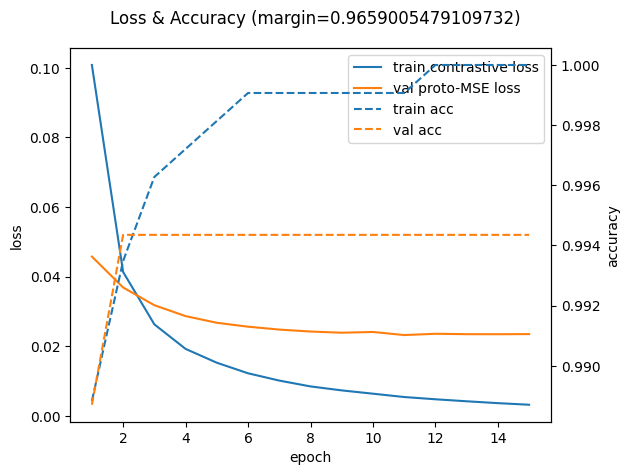

saved plot: contrastive_best/curves_margin0.9659005479109732.png
saved: contrastive_best/siamese_model.pt and contrastive_best/prototypes.csv
Best sim_threshold: 88.7036497686898

VAL (at tuned threshold)
  open-set macro_f1 (IDs+Stranger): 0.9234883119301945
  known-vs-unknown acc: 0.905
  known-vs-unknown macro_f1: 0.8162386962619081
  full open-set accuracy (IDs+Stranger): 0.905

VAL (best TPR subject to FAR<=5%)
  th: 89.2  FAR: 0.043478260869565216  TPR_known: 0.903954802259887


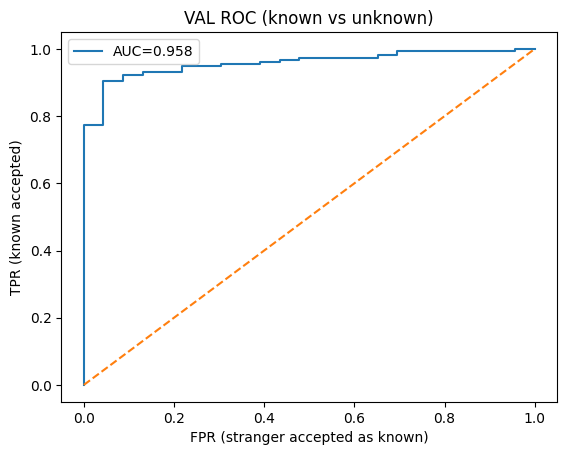


TEST (at tuned threshold)
  open-set macro_f1 (IDs+Stranger): 0.9591069908614063
  known-vs-unknown acc: 0.9483568075117371
  known-vs-unknown macro_f1: 0.888603622878334
  full open-set accuracy (IDs+Stranger): 0.9483568075117371

TEST (best TPR subject to FAR<=5%)
  th: 87.2  FAR: 0.041666666666666664  TPR_known: 0.9682539682539683


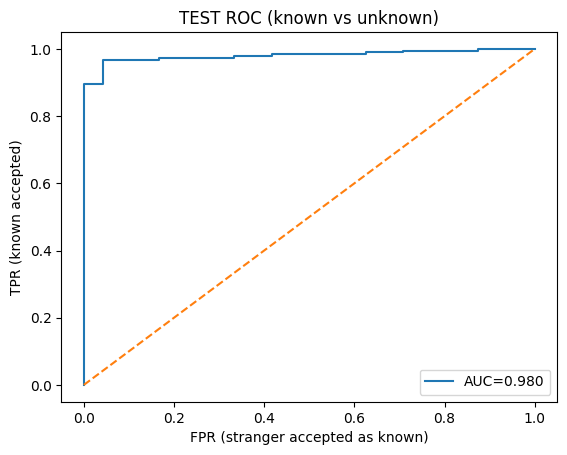

In [4]:
from pathlib import Path
import numpy as np
from sklearn.metrics import accuracy_score

best = study.best_params

HP = dict(
    dropout=best["dropout"],
    margin=best["margin"],
    lr=best["lr"],
    weight_decay=best["weight_decay"],
    epochs=best["epochs"],
    batch_size=best["batch_size"],
    num_pairs_per_epoch=best["num_pairs_per_epoch"],
    pos_fraction=1/3,
    prefix="e", folder_col="folder_name", file_col="file_name",
    seed=SEED,
    sim_threshold=best["sim_threshold"],
)

OUT = Path("contrastive_best")
OUT.mkdir(exist_ok=True)

cfg = Cfg(**HP)
m = Siamese(cfg, device=DEVICE)
m.fit(TRAIN, val_csv=VAL, out_dir=OUT)
m.load_prototypes(OUT / "prototypes.csv")

print("Best sim_threshold:", m.cfg.sim_threshold)

def tpr_at_far(known_scores, str_scores, far_max=0.05):
    # accept known if sim >= th
    # FAR(th) = fraction of strangers accepted as known
    ths = np.linspace(0, 100, 1001)
    best = {"tpr": -1, "th": None, "far": None}
    for th in ths:
        far = float((str_scores >= th).mean())
        if far <= far_max:
            tpr = float((known_scores >= th).mean())
            if tpr > best["tpr"]:
                best = {"tpr": tpr, "th": float(th), "far": far}
    return best

def full_openset_accuracy(model, known_csv, str_csv, th):
    k = model.predict_csv(known_csv, out_csv="__tmp_k.csv")
    u = model.predict_csv(str_csv,   out_csv="__tmp_u.csv")

    # apply thresholded "Stranger" gating ourselves
    k_pred = np.where(k["similarity_percent"].to_numpy() < th, "Stranger",
                      k["pred_folder_name"].astype(str).to_numpy())
    u_pred = np.where(u["similarity_percent"].to_numpy() < th, "Stranger",
                      u["pred_folder_name"].astype(str).to_numpy())

    y_true = np.concatenate([k["folder_name"].astype(str).to_numpy(),
                             np.array(["Stranger"] * len(u))])
    y_pred = np.concatenate([k_pred, u_pred])
    return float(accuracy_score(y_true, y_pred))

# ---------------- VAL ----------------
val_open_f1 = open_set_macro_f1(m, VAL, VAL_STR, m.cfg.sim_threshold)
val_bin = known_unknown_metrics(m, VAL, VAL_STR, m.cfg.sim_threshold)
val_full_acc = full_openset_accuracy(m, VAL, VAL_STR, m.cfg.sim_threshold)

opt_val = tpr_at_far(val_bin["known_scores"], val_bin["str_scores"], far_max=0.05)

print("\nVAL (at tuned threshold)")
print("  open-set macro_f1 (IDs+Stranger):", val_open_f1)
print("  known-vs-unknown acc:", val_bin["acc"])
print("  known-vs-unknown macro_f1:", val_bin["macro_f1"])
print("  full open-set accuracy (IDs+Stranger):", val_full_acc)

print("\nVAL (best TPR subject to FAR<=5%)")
print("  th:", opt_val["th"], " FAR:", opt_val["far"], " TPR_known:", opt_val["tpr"])

plot_roc(val_bin["known_scores"], val_bin["str_scores"], "VAL ROC (known vs unknown)")

# ---------------- TEST ----------------
test_open_f1 = open_set_macro_f1(m, TEST, TEST_STR, m.cfg.sim_threshold)
test_bin = known_unknown_metrics(m, TEST, TEST_STR, m.cfg.sim_threshold)
test_full_acc = full_openset_accuracy(m, TEST, TEST_STR, m.cfg.sim_threshold)

opt_test = tpr_at_far(test_bin["known_scores"], test_bin["str_scores"], far_max=0.05)

print("\nTEST (at tuned threshold)")
print("  open-set macro_f1 (IDs+Stranger):", test_open_f1)
print("  known-vs-unknown acc:", test_bin["acc"])
print("  known-vs-unknown macro_f1:", test_bin["macro_f1"])
print("  full open-set accuracy (IDs+Stranger):", test_full_acc)

print("\nTEST (best TPR subject to FAR<=5%)")
print("  th:", opt_test["th"], " FAR:", opt_test["far"], " TPR_known:", opt_test["tpr"])

plot_roc(test_bin["known_scores"], test_bin["str_scores"], "TEST ROC (known vs unknown)")
